In [1]:
!pip install spuco torch torchvision scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=82d95807ec41b8d31e74d649aceeed24c868138e021819628344ae5180b8456e
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from torchvision import transforms

# SpuCo imports
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
from spuco.utils import set_seed

set_seed(12345) # Just to get reproducible results everytime like in the hw

In [ ]:
from spuco.models import model_factory
from spuco.utils import Trainer
from torch.optim import Adam
from torch.optim import SGD
import torch.nn.functional as F

# This is the "dumb" agent that picks up on spurious features quick, if my hypotehsis is correct.
class FullModel(nn.Module):
    def __init__(self, num_classes=5):
        super(SmallBiasedModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_input_dim = 32 * 7 * 7

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits


# This one has an 8x8 input, specifically for MNIST because the images are tiny there.
class SmallBiasedMNISTModel(nn.Module):
    def __init__(self, num_classes=5):
        super(SmallBiasedMNISTModel, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),


            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_input_dim = 32 * 2 * 2

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits

class SmallerBiasedMNISTModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # Input: (3, 4, 4)
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1) 

        self.fc = nn.Linear(16 * 4 * 4, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x))  
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x

In [ ]:
def train_bias_model(model, loader, device, epochs=5):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print(f"Training bias model for {epochs} epochs")
    for epoch in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

In [5]:



num_classes = 5
SCALAR_CONSTANT = 2

def get_logits_and_cluster(model, dataset, device, n_clusters):
    #I want to get the logits, append the labels (see report for study) and cluster
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_logits.append(outputs.cpu().numpy())
            one_hot = F.one_hot(labels, num_classes=num_classes).cpu().numpy()
            one_hot *= SCALAR_CONSTANT
            all_labels.append(one_hot)

    logits = np.concatenate(all_logits, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    logits = np.hstack([logits, labels])

    # Clustering
    print(f"n_clusters {n_clusters}")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(logits)

    #Pick a balanced number
    cluster_counts = Counter(cluster_labels)
    min_size = min(cluster_counts.values())
    print(f"n_cluster actual {cluster_counts}")
    print(f"smallest cluster {min_size}")

    for cluster_id in range(n_clusters):
        indices_in_cluster = np.where(cluster_labels == cluster_id)[0]
        sample_indices = np.random.choice(indices_in_cluster, 3, replace=False)

        fig, axes = plt.subplots(1, 3, figsize=(6, 2))
        for i, idx in enumerate(sample_indices):
            img, _ = dataset[idx]
            img = img.permute(1, 2, 0) if img.ndim == 3 else img  # you get some grayscale in birds
            axes[i].imshow(img.squeeze(), cmap='gray' if img.ndim == 2 else None)
            axes[i].axis('off')
            #axes[i].set_title(f"Idx {idx}")
        plt.suptitle(f"Cluster {cluster_id}")
        plt.show()

    selected_indices = []
    for cluster_id in range(n_clusters):
        # Indices in the dataset corresponding to this cluster
        indices_in_cluster = np.where(cluster_labels == cluster_id)[0]
        # Randomly sample min_size
        selected = np.random.choice(indices_in_cluster, min_size, replace=False)
        selected_indices.extend(selected)

    return selected_indices

In [ ]:



from spuco.robust_train import ERM
device = "cuda" if torch.cuda.is_available() else "cpu"

Classes = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
num_classes = len(Classes) # Should be 5
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_MEDIUM
correlation_strength = 0.95 #CHANGEME for results


low_res_size = 8
low_res_transform = transforms.Compose([
    transforms.Resize((low_res_size, low_res_size), interpolation=transforms.InterpolationMode.NEAREST)
])

print("Initializing Bias Dataset")
bias_trainset = SpuCoMNIST(
    root="data/dataset",
    split="train",
    classes=Classes,
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=correlation_strength,
    transform=low_res_transform
)
bias_trainset.initialize()


final_trainset = SpuCoMNIST(
    root="data/dataset",
    split="train",
    classes=Classes,
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=correlation_strength,
)
final_trainset.initialize()

final_trainset_selector = SpuCoMNIST(
    root="data/dataset",
    split="train",
    classes=Classes,
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=correlation_strength,
    transform=low_res_transform
)
final_trainset_selector.initialize()


Initializing Bias Dataset (8x8 Res)...
Initializing Final Dataset (Standard Res)...


Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

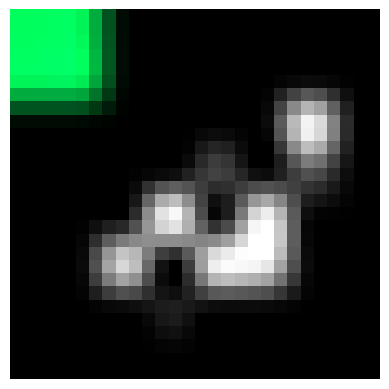

In [26]:
# VERY IMPORTANT !!!!!!!
# Check this to make sure that the model didn't "cheat" by removing the colored corner boxes for weakly learned features.
# If you don't transform it correctly, it achieves extremely high accuracy that way.

import torchvision.transforms as T
image = T.ToPILImage()(bias_trainset[9][0]).resize((28, 28))
import matplotlib.pyplot as plt

plt.imshow(image)
plt.axis("off")

In [ ]:

bias_loader = DataLoader(bias_trainset, batch_size=64, shuffle=True)

bias_model = SmallBiasedMNISTModel(num_classes=num_classes).to(device)
bias_model = train_bias_model(bias_model, bias_loader, device, epochs=2)

Training bias model (Resolution: Low) for 2 epochs...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating group-wise accuracy:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:20,  1.16it/s]

Group (0, 0) Accuracy: 99.29078014184397


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:01<00:19,  1.17it/s]

Group (0, 1) Accuracy: 61.22931442080378


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:02<00:19,  1.16it/s]

Group (0, 2) Accuracy: 54.846335697399525


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:03<00:17,  1.17it/s]

Group (0, 3) Accuracy: 51.773049645390074


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:04<00:18,  1.09it/s]

Group (0, 4) Accuracy: 41.13475177304964


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:05<00:20,  1.06s/it]

Group (1, 0) Accuracy: 81.90709046454768


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:06<00:19,  1.07s/it]

Group (1, 1) Accuracy: 99.75550122249389


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:07<00:17,  1.00s/it]

Group (1, 2) Accuracy: 60.049019607843135


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:08<00:15,  1.05it/s]

Group (1, 3) Accuracy: 46.81372549019608


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:09<00:13,  1.10it/s]

Group (1, 4) Accuracy: 60.53921568627451


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:10<00:12,  1.12it/s]

Group (2, 0) Accuracy: 72.53333333333333


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:11<00:11,  1.14it/s]

Group (2, 1) Accuracy: 46.13333333333333


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:11<00:10,  1.16it/s]

Group (2, 2) Accuracy: 99.46666666666667


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:12<00:09,  1.19it/s]

Group (2, 3) Accuracy: 56.8


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:13<00:08,  1.20it/s]

Group (2, 4) Accuracy: 15.508021390374331


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:14<00:07,  1.19it/s]

Group (3, 0) Accuracy: 65.32663316582915


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:15<00:06,  1.18it/s]

Group (3, 1) Accuracy: 34.005037783375315


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:16<00:05,  1.17it/s]

Group (3, 2) Accuracy: 49.37027707808564


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:17<00:05,  1.13it/s]

Group (3, 3) Accuracy: 99.49622166246851


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:18<00:05,  1.01s/it]

Group (3, 4) Accuracy: 52.141057934508815


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:19<00:04,  1.02s/it]

Group (4, 0) Accuracy: 62.21662468513854


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:20<00:02,  1.03it/s]

Group (4, 1) Accuracy: 24.43324937027708


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:21<00:01,  1.07it/s]

Group (4, 2) Accuracy: 1.0075566750629723


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:21<00:00,  1.10it/s]

Group (4, 3) Accuracy: 24.494949494949495


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]

Group (4, 4) Accuracy: 98.98989898989899

Worst group accuracy:  ((4, 2), 1.0075566750629723)

Average accuracy: 58.49000000000001
{(0, 0): 99.29078014184397, (0, 1): 61.22931442080378, (0, 2): 54.846335697399525, (0, 3): 51.773049645390074, (0, 4): 41.13475177304964, (1, 0): 81.90709046454768, (1, 1): 99.75550122249389, (1, 2): 60.049019607843135, (1, 3): 46.81372549019608, (1, 4): 60.53921568627451, (2, 0): 72.53333333333333, (2, 1): 46.13333333333333, (2, 2): 99.46666666666667, (2, 3): 56.8, (2, 4): 15.508021390374331, (3, 0): 65.32663316582915, (3, 1): 34.005037783375315, (3, 2): 49.37027707808564, (3, 3): 99.49622166246851, (3, 4): 52.141057934508815, (4, 0): 62.21662468513854, (4, 1): 24.43324937027708, (4, 2): 1.0075566750629723, (4, 3): 24.494949494949495, (4, 4): 98.98989898989899}


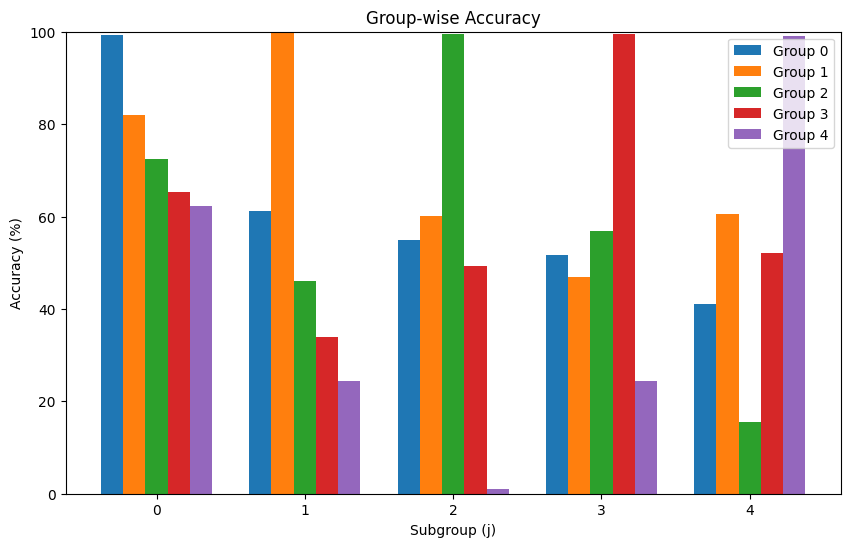

In [ ]:
# Small check: Did my model learn the spurious feature?

from spuco.evaluate import Evaluator

# From hw
spurious_test_ds = SpuCoMNIST(root="data/dataset",
                     spurious_feature_difficulty=difficulty,
                     classes=Classes,
                     spurious_correlation_strength=correlation_strength,
                     split="test",
                     download=True,
                     transform=low_res_transform)
spurious_test_ds.initialize()

evaluator = Evaluator(
    testset=spurious_test_ds,
    group_partition=spurious_test_ds.group_partition,
    group_weights=spurious_test_ds.group_weights,
    batch_size=64,
    model=bias_model,
    device=device,
    verbose=True
)
evaluator.evaluate()
print("Worst group accuracy: ", evaluator.worst_group_accuracy)
print("Average accuracy:", evaluator.average_accuracy)

print(evaluator.accuracies)

import matplotlib.pyplot as plt

accuracy_dict = evaluator.accuracies

groups = sorted(set(key[0] for key in accuracy_dict.keys()))
subgroups = sorted(set(key[1] for key in accuracy_dict.keys()))

data = [[accuracy_dict[(i, j)] for j in subgroups] for i in groups]

# Bar graph parameters
x = np.arange(len(subgroups))  # x locations for subgroups
width = 0.15  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each group
for i, group_data in enumerate(data):
    ax.bar(x + i*width, group_data, width, label=f'Group {i}')

# Labels and formatting
ax.set_xlabel('Subgroup (j)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Group-wise Accuracy')
ax.set_xticks(x + width * (len(groups)-1)/2)
ax.set_xticklabels(subgroups)
ax.set_ylim(0, 100)
ax.legend()

plt.show()

n_clusters 15
n_cluster actual Counter({np.int32(3): 5634, np.int32(2): 4984, np.int32(12): 4202, np.int32(6): 4102, np.int32(0): 3723, np.int32(8): 3126, np.int32(11): 3012, np.int32(9): 2977, np.int32(5): 2971, np.int32(10): 2700, np.int32(7): 2694, np.int32(1): 2497, np.int32(14): 2163, np.int32(4): 2101, np.int32(13): 1118})
smallest cluster 1118


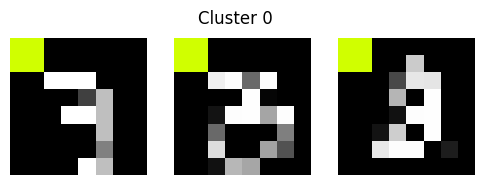

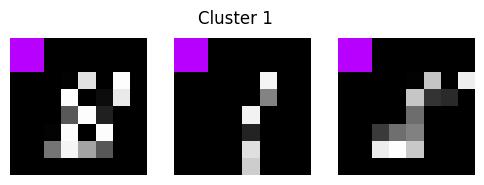

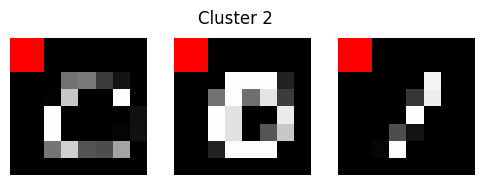

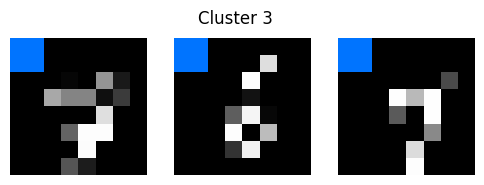

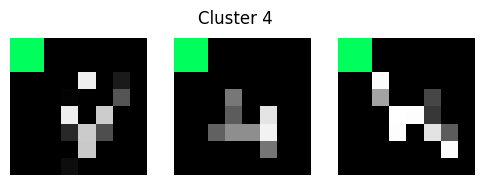

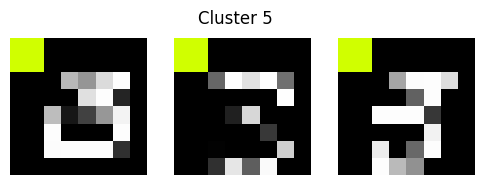

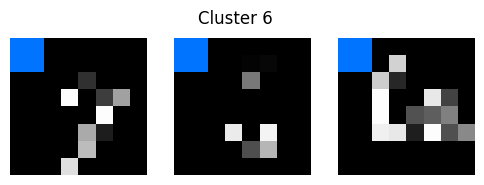

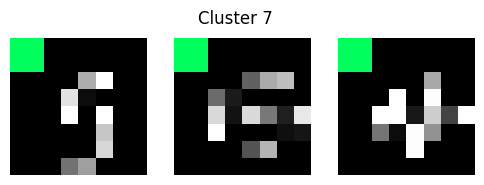

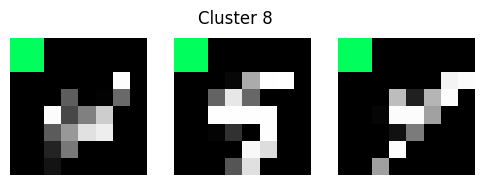

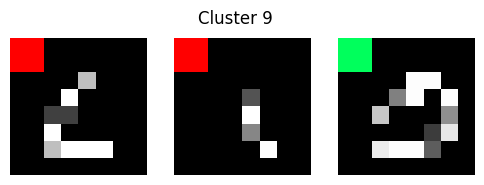

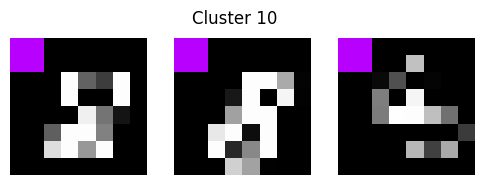

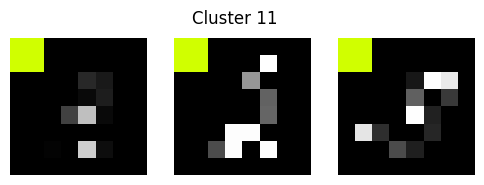

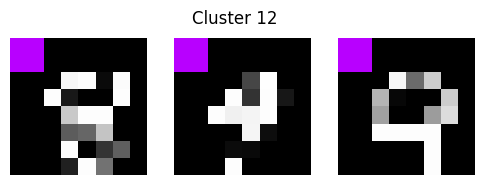

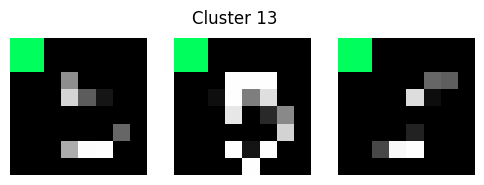

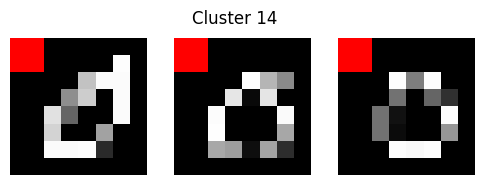

Data Selection: Kept 16770 / 48004 samples
Data selection done


In [ ]:


selected_indices = get_logits_and_cluster(bias_model, final_trainset_selector, device, n_clusters=15)

print(f"Data Selection: Kept {len(selected_indices)} / {len(final_trainset)} samples")


#Create the "Clean" Subset using indices derived from the low-res model
clean_dataset = Subset(final_trainset, selected_indices)


print("Data selection done")


In [34]:

input_size = final_trainset[0][0].shape
num_labels = final_trainset.num_classes
model_lenet = model_factory("lenet", input_size, num_labels).to(device)

optimizer_adam = Adam(
    model_lenet.parameters(),
    lr=0.001
)
ermtrainer = ERM(
    trainset=clean_dataset,
    model=model_lenet,
    num_epochs=5,
    batch_size=32,
    optimizer=SGD(model_lenet.parameters(), lr=0.001, momentum=0.9, nesterov=True), #optimizer_adam,
    device=device,
    verbose=True
)

# Start training
ermtrainer.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 0:   0%|          | 0/525 [00:00<?, ?batch/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 0:   1%|▏         | 7/525 [00:00<00:35, 14.48batch/s, accuracy=6.25%, loss=1.64]

ERM | Epoch 0 | Loss: 1.6358084678649902 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.639343500137329 | Accuracy: 6.25%
ERM | Epoch 0 | Loss: 1.6334760189056396 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6345397233963013 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6004159450531006 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6307196617126465 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6073133945465088 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6413322687149048 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.605506181716919 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6309915781021118 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6233720779418945 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6353763341903687 | Accuracy: 6.25%


Epoch 0:   4%|▍         | 20/525 [00:00<00:14, 34.99batch/s, accuracy=21.875%, loss=1.61]

ERM | Epoch 0 | Loss: 1.6007094383239746 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6461234092712402 | Accuracy: 3.125%
ERM | Epoch 0 | Loss: 1.6096593141555786 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6330206394195557 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6141080856323242 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6114506721496582 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6315330266952515 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6221059560775757 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6258295774459839 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6110479831695557 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6350295543670654 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6112865209579468 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6083602905273438 | Accuracy: 21.875%


Epoch 0:   6%|▋         | 34/525 [00:01<00:10, 47.63batch/s, accuracy=3.125%, loss=1.63]

ERM | Epoch 0 | Loss: 1.6235579252243042 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6232026815414429 | Accuracy: 3.125%
ERM | Epoch 0 | Loss: 1.6276111602783203 | Accuracy: 3.125%
ERM | Epoch 0 | Loss: 1.6365770101547241 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6133424043655396 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6163636445999146 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6192854642868042 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.615447759628296 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6309585571289062 | Accuracy: 6.25%
ERM | Epoch 0 | Loss: 1.634478211402893 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6224747896194458 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6307611465454102 | Accuracy: 3.125%


Epoch 0:   9%|▉         | 46/525 [00:01<00:09, 52.05batch/s, accuracy=21.875%, loss=1.61]

ERM | Epoch 0 | Loss: 1.6049906015396118 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6156102418899536 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.607617735862732 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6082755327224731 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.606266736984253 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6205633878707886 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6133369207382202 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.604021430015564 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6283220052719116 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6122453212738037 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6085808277130127 | Accuracy: 21.875%


Epoch 0:  10%|▉         | 52/525 [00:01<00:10, 47.12batch/s, accuracy=3.125%, loss=1.64] 

ERM | Epoch 0 | Loss: 1.6107786893844604 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6243199110031128 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6094999313354492 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6259853839874268 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6147549152374268 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6184158325195312 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6138659715652466 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6247309446334839 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6390862464904785 | Accuracy: 3.125%


Epoch 0:  12%|█▏        | 63/525 [00:01<00:10, 46.14batch/s, accuracy=3.125%, loss=1.62]

ERM | Epoch 0 | Loss: 1.6132296323776245 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6128333806991577 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6062986850738525 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6171727180480957 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6038637161254883 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5974222421646118 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6261690855026245 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.617673397064209 | Accuracy: 6.25%
ERM | Epoch 0 | Loss: 1.6046222448349 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.618963599205017 | Accuracy: 3.125%


Epoch 0:  14%|█▍        | 73/525 [00:01<00:09, 46.66batch/s, accuracy=6.25%, loss=1.61] 

ERM | Epoch 0 | Loss: 1.6137081384658813 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5963084697723389 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6225535869598389 | Accuracy: 6.25%
ERM | Epoch 0 | Loss: 1.605229377746582 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6005744934082031 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6184473037719727 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6203889846801758 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6126044988632202 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.61080002784729 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6098449230194092 | Accuracy: 6.25%


Epoch 0:  16%|█▌        | 84/525 [00:02<00:09, 46.90batch/s, accuracy=18.75%, loss=1.6] 

ERM | Epoch 0 | Loss: 1.604121446609497 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6155030727386475 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6239111423492432 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6088868379592896 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6159971952438354 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6143510341644287 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6072971820831299 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6132594347000122 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6109265089035034 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6047996282577515 | Accuracy: 18.75%


Epoch 0:  18%|█▊        | 94/525 [00:02<00:09, 46.83batch/s, accuracy=34.375%, loss=1.61]

ERM | Epoch 0 | Loss: 1.612635850906372 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.62114417552948 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6115748882293701 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5990033149719238 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6079505681991577 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5914802551269531 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6120498180389404 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6135845184326172 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6200881004333496 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6082088947296143 | Accuracy: 34.375%


Epoch 0:  20%|█▉        | 104/525 [00:02<00:09, 46.20batch/s, accuracy=37.5%, loss=1.61]

ERM | Epoch 0 | Loss: 1.6060669422149658 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6000962257385254 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6198397874832153 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6207748651504517 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.60567307472229 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6175998449325562 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.610398292541504 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6005936861038208 | Accuracy: 56.25%
ERM | Epoch 0 | Loss: 1.605360984802246 | Accuracy: 37.5%


Epoch 0:  22%|██▏       | 114/525 [00:02<00:09, 45.48batch/s, accuracy=43.75%, loss=1.6]

ERM | Epoch 0 | Loss: 1.5964325666427612 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6146271228790283 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6143121719360352 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6165084838867188 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.600879430770874 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6147228479385376 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.612933874130249 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6096558570861816 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.604184865951538 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5987180471420288 | Accuracy: 43.75%


Epoch 0:  24%|██▎       | 124/525 [00:03<00:09, 44.40batch/s, accuracy=28.125%, loss=1.61]

ERM | Epoch 0 | Loss: 1.6019984483718872 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5996389389038086 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5924574136734009 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.6110312938690186 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6227223873138428 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6051793098449707 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6103532314300537 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6064481735229492 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.607912540435791 | Accuracy: 28.125%


Epoch 0:  26%|██▌       | 134/525 [00:03<00:08, 44.85batch/s, accuracy=18.75%, loss=1.62]

ERM | Epoch 0 | Loss: 1.5842374563217163 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5998296737670898 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.605628490447998 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.607983112335205 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.609152913093567 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6164337396621704 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.61937415599823 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6040414571762085 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6101347208023071 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.617398738861084 | Accuracy: 18.75%


Epoch 0:  27%|██▋       | 144/525 [00:03<00:08, 45.08batch/s, accuracy=28.125%, loss=1.61]

ERM | Epoch 0 | Loss: 1.5875637531280518 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6018027067184448 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6038553714752197 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6152236461639404 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.610448956489563 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5855525732040405 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.5970351696014404 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6183117628097534 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6056708097457886 | Accuracy: 28.125%


Epoch 0:  29%|██▉       | 154/525 [00:03<00:08, 46.18batch/s, accuracy=34.375%, loss=1.59]

ERM | Epoch 0 | Loss: 1.5936733484268188 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5979138612747192 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.61848783493042 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5994430780410767 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.594393014907837 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.6056101322174072 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6068998575210571 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6129642724990845 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5952098369598389 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5920650959014893 | Accuracy: 34.375%


Epoch 0:  30%|███       | 159/525 [00:03<00:08, 44.84batch/s, accuracy=34.375%, loss=1.59]

ERM | Epoch 0 | Loss: 1.613073468208313 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.608896017074585 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.595718502998352 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6033918857574463 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6101291179656982 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5996613502502441 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5957881212234497 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6099658012390137 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5840197801589966 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.6127643585205078 | Accuracy: 21.875%


Epoch 0:  33%|███▎      | 172/525 [00:04<00:06, 52.17batch/s, accuracy=28.125%, loss=1.6]

ERM | Epoch 0 | Loss: 1.5945335626602173 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5958505868911743 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5958225727081299 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5954691171646118 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.603559970855713 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6027336120605469 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6109360456466675 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.603320598602295 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6099421977996826 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6143407821655273 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5849084854125977 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5999130010604858 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.597813606262207 | Accuracy: 28.125%


Epoch 0:  35%|███▌      | 186/525 [00:04<00:05, 57.88batch/s, accuracy=37.5%, loss=1.59]  

ERM | Epoch 0 | Loss: 1.6176860332489014 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6080385446548462 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6121925115585327 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6188690662384033 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6124662160873413 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5730124711990356 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.5899178981781006 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6056604385375977 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5930012464523315 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6212754249572754 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5989280939102173 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6072527170181274 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.589442491531372 | Accuracy: 37.5%


Epoch 0:  38%|███▊      | 200/525 [00:04<00:05, 62.10batch/s, accuracy=21.875%, loss=1.61]

ERM | Epoch 0 | Loss: 1.5851212739944458 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.605934977531433 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6066381931304932 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5911792516708374 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5983026027679443 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5861735343933105 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6021888256072998 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6028300523757935 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5870565176010132 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6063907146453857 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6069074869155884 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5861709117889404 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5856138467788696 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.61497163772583 | Accuracy: 21.875%


Epoch 0:  41%|████      | 214/525 [00:04<00:04, 64.24batch/s, accuracy=34.375%, loss=1.59]

ERM | Epoch 0 | Loss: 1.617751955986023 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5958137512207031 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6192888021469116 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.576567530632019 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.597983717918396 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5864906311035156 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5835790634155273 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.60025954246521 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.608749508857727 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5942503213882446 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5920919179916382 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6142925024032593 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5932426452636719 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5853867530822754 | Accuracy: 34.375%


Epoch 0:  43%|████▎     | 228/525 [00:04<00:04, 63.16batch/s, accuracy=25.0%, loss=1.6]   

ERM | Epoch 0 | Loss: 1.600213885307312 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6111648082733154 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6094874143600464 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.599358081817627 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.614197850227356 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.601513147354126 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6039854288101196 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6099131107330322 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.594987154006958 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6113996505737305 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6192221641540527 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5847529172897339 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5998975038528442 | Accuracy: 25.0%


Epoch 0:  46%|████▌     | 242/525 [00:05<00:04, 63.54batch/s, accuracy=28.125%, loss=1.59]

ERM | Epoch 0 | Loss: 1.608249306678772 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.62930166721344 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6244436502456665 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.6156245470046997 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5916894674301147 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5676720142364502 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.586980938911438 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5925935506820679 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6078410148620605 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6022461652755737 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6095364093780518 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.590240240097046 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5947656631469727 | Accuracy: 28.125%


Epoch 0:  49%|████▉     | 256/525 [00:05<00:04, 64.67batch/s, accuracy=21.875%, loss=1.61]

ERM | Epoch 0 | Loss: 1.6221411228179932 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6030815839767456 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5807173252105713 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5915732383728027 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5921469926834106 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5961474180221558 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5993733406066895 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5976669788360596 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5913267135620117 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5673586130142212 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.6118789911270142 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5632392168045044 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.59224534034729 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.605108618736267 | Accuracy: 21.875%


Epoch 0:  51%|█████▏    | 270/525 [00:05<00:03, 63.95batch/s, accuracy=25.0%, loss=1.59]  

ERM | Epoch 0 | Loss: 1.6176812648773193 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5873017311096191 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5837470293045044 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5779424905776978 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5843424797058105 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5999011993408203 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.599511742591858 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.616593599319458 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5954926013946533 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.554276943206787 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.5892236232757568 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5850988626480103 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5927119255065918 | Accuracy: 25.0%


Epoch 0:  54%|█████▍    | 284/525 [00:05<00:03, 64.27batch/s, accuracy=40.625%, loss=1.56]

ERM | Epoch 0 | Loss: 1.5908374786376953 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.568036437034607 | Accuracy: 46.875%
ERM | Epoch 0 | Loss: 1.6095713376998901 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5781418085098267 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.597122073173523 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.608480453491211 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5912944078445435 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5942842960357666 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5612952709197998 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5863622426986694 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5643565654754639 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5781025886535645 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.622076153755188 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5635939836502075 | Accuracy: 40.625%


Epoch 0:  57%|█████▋    | 298/525 [00:05<00:03, 63.47batch/s, accuracy=34.375%, loss=1.57]

ERM | Epoch 0 | Loss: 1.5749505758285522 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5954437255859375 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5954264402389526 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5885677337646484 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6048063039779663 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6044957637786865 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5937788486480713 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6013368368148804 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5741804838180542 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5711559057235718 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.6067391633987427 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5981454849243164 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5663434267044067 | Accuracy: 34.375%


Epoch 0:  59%|█████▉    | 312/525 [00:06<00:03, 65.26batch/s, accuracy=46.875%, loss=1.54]

ERM | Epoch 0 | Loss: 1.5708823204040527 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6130958795547485 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.578784704208374 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.609015941619873 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5946805477142334 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5773026943206787 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5816658735275269 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6140605211257935 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6287230253219604 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5871796607971191 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.61326265335083 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6065102815628052 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6413288116455078 | Accuracy: 3.125%
ERM | Epoch 0 | Loss: 1.5393599271774292 | Accuracy: 46.875%


Epoch 0:  62%|██████▏   | 326/525 [00:06<00:03, 65.62batch/s, accuracy=18.75%, loss=1.59]

ERM | Epoch 0 | Loss: 1.5883152484893799 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5621094703674316 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5878911018371582 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.56851327419281 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.63608980178833 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5895733833312988 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5896598100662231 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.57257080078125 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.592767596244812 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.601761817932129 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5668957233428955 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5897424221038818 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6162052154541016 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5940487384796143 | Accuracy: 18.75%


Epoch 0:  63%|██████▎   | 333/525 [00:06<00:02, 64.88batch/s, accuracy=25.0%, loss=1.58]

ERM | Epoch 0 | Loss: 1.5748789310455322 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5881094932556152 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5624632835388184 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5992038249969482 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5807868242263794 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5792735815048218 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5696467161178589 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6150422096252441 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.59120512008667 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5847054719924927 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6001194715499878 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5624322891235352 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5803600549697876 | Accuracy: 25.0%


Epoch 0:  66%|██████▌   | 347/525 [00:06<00:02, 64.54batch/s, accuracy=21.875%, loss=1.57]

ERM | Epoch 0 | Loss: 1.5980480909347534 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.577479600906372 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6027195453643799 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.569584846496582 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6083183288574219 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5934618711471558 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5703125 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.57658851146698 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5874452590942383 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5850937366485596 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5932832956314087 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5513347387313843 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.5636003017425537 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5749729871749878 | Accuracy: 21.875%


Epoch 0:  69%|██████▉   | 361/525 [00:07<00:02, 63.29batch/s, accuracy=21.875%, loss=1.58]

ERM | Epoch 0 | Loss: 1.6057413816452026 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6108818054199219 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5597299337387085 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.6043708324432373 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5488001108169556 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.584728479385376 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5949403047561646 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.625925064086914 | Accuracy: 9.375%
ERM | Epoch 0 | Loss: 1.5785083770751953 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5896793603897095 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5805494785308838 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5452450513839722 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.584948182106018 | Accuracy: 21.875%


Epoch 0:  71%|███████▏  | 375/525 [00:07<00:02, 63.56batch/s, accuracy=18.75%, loss=1.6] 

ERM | Epoch 0 | Loss: 1.5935606956481934 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5720349550247192 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5970971584320068 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6019859313964844 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6204538345336914 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6481797695159912 | Accuracy: 6.25%
ERM | Epoch 0 | Loss: 1.5975539684295654 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5772771835327148 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6046464443206787 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.60133957862854 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5819405317306519 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6114411354064941 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5745400190353394 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.601601243019104 | Accuracy: 18.75%


Epoch 0:  74%|███████▍  | 389/525 [00:07<00:02, 63.30batch/s, accuracy=31.25%, loss=1.57] 

ERM | Epoch 0 | Loss: 1.5840353965759277 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5872464179992676 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5812017917633057 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5964415073394775 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5892488956451416 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6047240495681763 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.58627450466156 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.598239779472351 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.586147427558899 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5622037649154663 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.595986008644104 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6149009466171265 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5717360973358154 | Accuracy: 31.25%


Epoch 0:  77%|███████▋  | 403/525 [00:07<00:01, 64.49batch/s, accuracy=28.125%, loss=1.59]

ERM | Epoch 0 | Loss: 1.581761121749878 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5837352275848389 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5358221530914307 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.595322608947754 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.607712984085083 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6254738569259644 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5958530902862549 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5994774103164673 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5898573398590088 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.592374563217163 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.607696771621704 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5998784303665161 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.6041427850723267 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5865191221237183 | Accuracy: 28.125%


Epoch 0:  79%|███████▉  | 417/525 [00:07<00:01, 64.43batch/s, accuracy=12.5%, loss=1.62] 

ERM | Epoch 0 | Loss: 1.5675554275512695 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6201109886169434 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.553396463394165 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5601335763931274 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5929932594299316 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5983446836471558 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.561174750328064 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5556594133377075 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6188819408416748 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5877896547317505 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5488402843475342 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.579902172088623 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6191508769989014 | Accuracy: 12.5%


Epoch 0:  82%|████████▏ | 431/525 [00:08<00:01, 63.52batch/s, accuracy=46.875%, loss=1.53]

ERM | Epoch 0 | Loss: 1.592018961906433 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5537941455841064 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5852925777435303 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5912529230117798 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.579339623451233 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6037098169326782 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5926769971847534 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5896462202072144 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5740007162094116 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5799586772918701 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5409669876098633 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5930285453796387 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5330170392990112 | Accuracy: 46.875%


Epoch 0:  85%|████████▍ | 445/525 [00:08<00:01, 63.46batch/s, accuracy=25.0%, loss=1.59] 

ERM | Epoch 0 | Loss: 1.6032335758209229 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5785092115402222 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.57333505153656 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6312075853347778 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5912482738494873 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5983006954193115 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5725332498550415 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5770962238311768 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5585702657699585 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5906978845596313 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5359286069869995 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.5761795043945312 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.56598699092865 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5908633470535278 | Accuracy: 25.0%


Epoch 0:  87%|████████▋ | 459/525 [00:08<00:01, 64.84batch/s, accuracy=34.375%, loss=1.58]

ERM | Epoch 0 | Loss: 1.5557777881622314 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6193262338638306 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.576517105102539 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6112004518508911 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5793994665145874 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5628135204315186 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5450669527053833 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.6133311986923218 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5723555088043213 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6125991344451904 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.591813564300537 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5756797790527344 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5622864961624146 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5808428525924683 | Accuracy: 34.375%


Epoch 0:  90%|█████████ | 473/525 [00:08<00:00, 64.29batch/s, accuracy=21.875%, loss=1.6] 

ERM | Epoch 0 | Loss: 1.58963143825531 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.564240574836731 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6060724258422852 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.62165367603302 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.6206238269805908 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5829025506973267 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5849745273590088 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5480605363845825 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6065821647644043 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5553581714630127 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5650079250335693 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5254091024398804 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.585387110710144 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5986541509628296 | Accuracy: 21.875%


Epoch 0:  93%|█████████▎| 487/525 [00:08<00:00, 65.08batch/s, accuracy=34.375%, loss=1.56]

ERM | Epoch 0 | Loss: 1.584832787513733 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5773600339889526 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6068713665008545 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5971475839614868 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5820616483688354 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.6121982336044312 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.581467866897583 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5602750778198242 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.6122565269470215 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5951975584030151 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5970637798309326 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.604888916015625 | Accuracy: 18.75%
ERM | Epoch 0 | Loss: 1.5616505146026611 | Accuracy: 34.375%


Epoch 0:  95%|█████████▌| 501/525 [00:09<00:00, 63.46batch/s, accuracy=21.875%, loss=1.59]

ERM | Epoch 0 | Loss: 1.6128289699554443 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6203246116638184 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5506830215454102 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5448838472366333 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5792241096496582 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.6271408796310425 | Accuracy: 15.625%
ERM | Epoch 0 | Loss: 1.5747482776641846 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5896352529525757 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5841904878616333 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5305392742156982 | Accuracy: 40.625%
ERM | Epoch 0 | Loss: 1.5957005023956299 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.580876350402832 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5889211893081665 | Accuracy: 21.875%


Epoch 0:  97%|█████████▋| 508/525 [00:09<00:00, 62.38batch/s, accuracy=28.125%, loss=1.55]

ERM | Epoch 0 | Loss: 1.5518128871917725 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.558961272239685 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.612229585647583 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5601832866668701 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5775146484375 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5203560590744019 | Accuracy: 43.75%
ERM | Epoch 0 | Loss: 1.5650899410247803 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5596545934677124 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5987741947174072 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5957751274108887 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5481324195861816 | Accuracy: 34.375%
ERM | Epoch 0 | Loss: 1.5962417125701904 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5486516952514648 | Accuracy: 28.125%


Epoch 0:  99%|█████████▉| 522/525 [00:09<00:00, 64.80batch/s, accuracy=0.0%, loss=1.74] 

ERM | Epoch 0 | Loss: 1.5914885997772217 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.5631064176559448 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5970627069473267 | Accuracy: 31.25%
ERM | Epoch 0 | Loss: 1.5886560678482056 | Accuracy: 28.125%
ERM | Epoch 0 | Loss: 1.5581743717193604 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.563698649406433 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.5768390893936157 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6074795722961426 | Accuracy: 21.875%
ERM | Epoch 0 | Loss: 1.610718011856079 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5624802112579346 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.73789381980896 | Accuracy: 0.0%


Epoch 1:   1%|          | 6/525 [00:00<00:40, 12.87batch/s, accuracy=15.625%, loss=1.6]

ERM | Epoch 1 | Loss: 1.592911958694458 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5305193662643433 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5638947486877441 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.611262559890747 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5911089181900024 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5744881629943848 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.6209408044815063 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.5582048892974854 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5592021942138672 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5017286539077759 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.5964195728302002 | Accuracy: 15.625%


Epoch 1:   4%|▎         | 19/525 [00:00<00:14, 34.86batch/s, accuracy=25.0%, loss=1.59]  

ERM | Epoch 1 | Loss: 1.6335166692733765 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5670567750930786 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5493149757385254 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5945478677749634 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5540952682495117 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.561381459236145 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5871596336364746 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.551472544670105 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.6269659996032715 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.6014398336410522 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.594870686531067 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.556408405303955 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5869427919387817 | Accuracy: 25.0%


Epoch 1:   6%|▌         | 32/525 [00:01<00:10, 46.73batch/s, accuracy=18.75%, loss=1.6]  

ERM | Epoch 1 | Loss: 1.5638728141784668 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.6224509477615356 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5735112428665161 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.585337519645691 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5907137393951416 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.59476637840271 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.6011245250701904 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.550591230392456 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.6020565032958984 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.6250022649765015 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.5875493288040161 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5545369386672974 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5967533588409424 | Accuracy: 18.75%


Epoch 1:   9%|▊         | 45/525 [00:01<00:09, 51.08batch/s, accuracy=21.875%, loss=1.58]

ERM | Epoch 1 | Loss: 1.556861162185669 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.6024024486541748 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5769176483154297 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5782214403152466 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.611197590827942 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.551804780960083 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5697091817855835 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5858488082885742 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5475451946258545 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.6125882863998413 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5796644687652588 | Accuracy: 21.875%


Epoch 1:  11%|█         | 58/525 [00:01<00:08, 52.98batch/s, accuracy=25.0%, loss=1.58]  

ERM | Epoch 1 | Loss: 1.5577901601791382 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.6084686517715454 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5937923192977905 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.6031076908111572 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5803961753845215 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.576128363609314 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5734294652938843 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5847392082214355 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.527598261833191 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5556122064590454 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5626245737075806 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5778114795684814 | Accuracy: 25.0%


Epoch 1:  14%|█▎        | 72/525 [00:01<00:07, 58.15batch/s, accuracy=37.5%, loss=1.56]  

ERM | Epoch 1 | Loss: 1.5776727199554443 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5346978902816772 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5540063381195068 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5569838285446167 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5929381847381592 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.6436961889266968 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5389270782470703 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.601975917816162 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5893410444259644 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5986151695251465 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.6009867191314697 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5378860235214233 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5578874349594116 | Accuracy: 37.5%


Epoch 1:  16%|█▋        | 86/525 [00:01<00:07, 62.60batch/s, accuracy=43.75%, loss=1.52]

ERM | Epoch 1 | Loss: 1.550574779510498 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5590896606445312 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5658040046691895 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5657309293746948 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5359249114990234 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5561925172805786 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5753021240234375 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5729693174362183 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5718669891357422 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.6069012880325317 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5823445320129395 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5730910301208496 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5953046083450317 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5188524723052979 | Accuracy: 43.75%


Epoch 1:  19%|█▉        | 101/525 [00:02<00:06, 64.53batch/s, accuracy=31.25%, loss=1.53]

ERM | Epoch 1 | Loss: 1.5702369213104248 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5772064924240112 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5373601913452148 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.6102720499038696 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5802979469299316 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5702641010284424 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.520067811012268 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.6094043254852295 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5800572633743286 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.6191011667251587 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5536694526672363 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5797401666641235 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5995242595672607 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5342917442321777 | Accuracy: 31.25%


Epoch 1:  21%|██        | 108/525 [00:02<00:06, 64.05batch/s, accuracy=28.125%, loss=1.55]

ERM | Epoch 1 | Loss: 1.5801448822021484 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5925012826919556 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5310890674591064 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5722085237503052 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5350357294082642 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.6079810857772827 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5823445320129395 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5569218397140503 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5582468509674072 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5631433725357056 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.554111123085022 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5754095315933228 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5189275741577148 | Accuracy: 40.625%


Epoch 1:  23%|██▎       | 122/525 [00:02<00:06, 62.42batch/s, accuracy=28.125%, loss=1.56]

ERM | Epoch 1 | Loss: 1.552514672279358 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.6076992750167847 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5474772453308105 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5622060298919678 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5640705823898315 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5915669202804565 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5454967021942139 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.597840428352356 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5304768085479736 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5648670196533203 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.530555009841919 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5793347358703613 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5601136684417725 | Accuracy: 28.125%


Epoch 1:  26%|██▌       | 136/525 [00:02<00:06, 63.62batch/s, accuracy=25.0%, loss=1.56]  

ERM | Epoch 1 | Loss: 1.6121445894241333 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5699139833450317 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5522507429122925 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5762227773666382 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5548126697540283 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5284950733184814 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5987685918807983 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.6075477600097656 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.5810532569885254 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5586744546890259 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5349013805389404 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.4978384971618652 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.5590137243270874 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5646761655807495 | Accuracy: 25.0%


Epoch 1:  29%|██▉       | 151/525 [00:02<00:05, 65.98batch/s, accuracy=25.0%, loss=1.58]

ERM | Epoch 1 | Loss: 1.5729174613952637 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5273034572601318 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5282082557678223 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5220385789871216 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.6115976572036743 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.583910346031189 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.6421655416488647 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.56712806224823 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5622016191482544 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5680373907089233 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5682170391082764 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.6109577417373657 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5553010702133179 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5784038305282593 | Accuracy: 25.0%


Epoch 1:  31%|███▏      | 165/525 [00:03<00:05, 63.66batch/s, accuracy=25.0%, loss=1.56]  

ERM | Epoch 1 | Loss: 1.6243114471435547 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.6049315929412842 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.552596092224121 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.6449288129806519 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5822840929031372 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5370169878005981 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5726104974746704 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5690304040908813 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.535929560661316 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.6254057884216309 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.60523521900177 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5601316690444946 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.564734935760498 | Accuracy: 25.0%


Epoch 1:  34%|███▍      | 179/525 [00:03<00:05, 61.42batch/s, accuracy=31.25%, loss=1.58]

ERM | Epoch 1 | Loss: 1.5632102489471436 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5558961629867554 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5682860612869263 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.4871526956558228 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.5868711471557617 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5053963661193848 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.535519003868103 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5567115545272827 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5853527784347534 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5721418857574463 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5685358047485352 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.579554796218872 | Accuracy: 31.25%


Epoch 1:  37%|███▋      | 193/525 [00:03<00:05, 61.05batch/s, accuracy=25.0%, loss=1.6]   

ERM | Epoch 1 | Loss: 1.5957773923873901 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5073097944259644 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.508331298828125 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5533376932144165 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.588873267173767 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.4888989925384521 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.5209418535232544 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5453355312347412 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5981229543685913 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.539468765258789 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.52838134765625 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5817018747329712 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.6247193813323975 | Accuracy: 15.625%


Epoch 1:  39%|███▉      | 207/525 [00:03<00:04, 63.81batch/s, accuracy=28.125%, loss=1.54]

ERM | Epoch 1 | Loss: 1.6011701822280884 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5710331201553345 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5534396171569824 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.540027141571045 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5566107034683228 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.583086371421814 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.6083449125289917 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5694687366485596 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.603988766670227 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.48858642578125 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5798232555389404 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5643258094787598 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5679235458374023 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5420076847076416 | Accuracy: 28.125%


Epoch 1:  41%|████      | 214/525 [00:04<00:04, 63.77batch/s, accuracy=21.875%, loss=1.56]

ERM | Epoch 1 | Loss: 1.5654511451721191 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5429577827453613 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5442276000976562 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5699304342269897 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.5520778894424438 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.4948638677597046 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.561566948890686 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.6001203060150146 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5106163024902344 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.4996564388275146 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5661875009536743 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5581291913986206 | Accuracy: 21.875%


Epoch 1:  43%|████▎     | 228/525 [00:04<00:05, 53.12batch/s, accuracy=21.875%, loss=1.54]

ERM | Epoch 1 | Loss: 1.5471185445785522 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5737022161483765 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5586016178131104 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5793315172195435 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5452524423599243 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5834120512008667 | Accuracy: 9.375%
ERM | Epoch 1 | Loss: 1.5765156745910645 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5259021520614624 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.536584734916687 | Accuracy: 21.875%


Epoch 1:  45%|████▍     | 234/525 [00:04<00:05, 49.26batch/s, accuracy=28.125%, loss=1.51]

ERM | Epoch 1 | Loss: 1.6478888988494873 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.5707331895828247 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5066123008728027 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.5315366983413696 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.4816458225250244 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5097726583480835 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.6077793836593628 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.5536586046218872 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5092413425445557 | Accuracy: 28.125%


Epoch 1:  47%|████▋     | 245/525 [00:04<00:06, 45.17batch/s, accuracy=25.0%, loss=1.56] 

ERM | Epoch 1 | Loss: 1.54838228225708 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5462491512298584 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5566151142120361 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.537988543510437 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5883253812789917 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5956676006317139 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5915863513946533 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5644937753677368 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5604891777038574 | Accuracy: 25.0%


Epoch 1:  49%|████▊     | 255/525 [00:04<00:06, 44.61batch/s, accuracy=21.875%, loss=1.57]

ERM | Epoch 1 | Loss: 1.5297868251800537 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5287604331970215 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5035302639007568 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5461047887802124 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5444893836975098 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.4917594194412231 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.6063979864120483 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5152714252471924 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.54793381690979 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5654603242874146 | Accuracy: 21.875%


Epoch 1:  50%|█████     | 265/525 [00:05<00:05, 45.37batch/s, accuracy=12.5%, loss=1.58]  

ERM | Epoch 1 | Loss: 1.5108617544174194 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5618066787719727 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5797101259231567 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5293198823928833 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5183355808258057 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5270421504974365 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.582290768623352 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5541620254516602 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5810961723327637 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5752384662628174 | Accuracy: 12.5%


Epoch 1:  52%|█████▏    | 275/525 [00:05<00:05, 45.69batch/s, accuracy=31.25%, loss=1.53] 

ERM | Epoch 1 | Loss: 1.5452945232391357 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.517952561378479 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5642914772033691 | Accuracy: 6.25%
ERM | Epoch 1 | Loss: 1.5475680828094482 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5522749423980713 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.535313606262207 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5260812044143677 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.5278294086456299 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.4902015924453735 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5326933860778809 | Accuracy: 31.25%


Epoch 1:  54%|█████▍    | 285/525 [00:05<00:05, 46.78batch/s, accuracy=25.0%, loss=1.54]  

ERM | Epoch 1 | Loss: 1.5516387224197388 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5047706365585327 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5613012313842773 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5439832210540771 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5165467262268066 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.4937665462493896 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5425928831100464 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.5292408466339111 | Accuracy: 15.625%
ERM | Epoch 1 | Loss: 1.5274746417999268 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5372071266174316 | Accuracy: 25.0%


Epoch 1:  56%|█████▌    | 295/525 [00:05<00:04, 47.18batch/s, accuracy=37.5%, loss=1.53] 

ERM | Epoch 1 | Loss: 1.5287052392959595 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5254385471343994 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5642693042755127 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.4965918064117432 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.510575532913208 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5461347103118896 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5470669269561768 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5364437103271484 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5283520221710205 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5292465686798096 | Accuracy: 37.5%


Epoch 1:  58%|█████▊    | 306/525 [00:05<00:04, 48.06batch/s, accuracy=40.625%, loss=1.59]

ERM | Epoch 1 | Loss: 1.5938267707824707 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5263115167617798 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5887430906295776 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.655192255973816 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.5754684209823608 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.517923355102539 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5049291849136353 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.477271556854248 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.5088480710983276 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5904605388641357 | Accuracy: 40.625%


Epoch 1:  59%|█████▉    | 311/525 [00:06<00:04, 46.34batch/s, accuracy=43.75%, loss=1.55]

ERM | Epoch 1 | Loss: 1.5249481201171875 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5407341718673706 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5566105842590332 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5590025186538696 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.5505071878433228 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.468018651008606 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.5373985767364502 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.546553611755371 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5457359552383423 | Accuracy: 43.75%


Epoch 1:  61%|██████▏   | 322/525 [00:06<00:04, 47.29batch/s, accuracy=34.375%, loss=1.49]

ERM | Epoch 1 | Loss: 1.4774458408355713 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.4467602968215942 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.4910454750061035 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.4737762212753296 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.4900603294372559 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.538636326789856 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.5278756618499756 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5369504690170288 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.4848202466964722 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.485937476158142 | Accuracy: 34.375%


Epoch 1:  63%|██████▎   | 332/525 [00:06<00:04, 44.43batch/s, accuracy=46.875%, loss=1.53]

ERM | Epoch 1 | Loss: 1.4839481115341187 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.4689666032791138 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.4880449771881104 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.5326929092407227 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5460680723190308 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.5084770917892456 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.4846657514572144 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.4256337881088257 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.5343607664108276 | Accuracy: 46.875%


Epoch 1:  65%|██████▌   | 342/525 [00:06<00:04, 42.66batch/s, accuracy=37.5%, loss=1.47]

ERM | Epoch 1 | Loss: 1.4836357831954956 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.4681318998336792 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.502402901649475 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.457105040550232 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.5297073125839233 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.4410375356674194 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.5200152397155762 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5022858381271362 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.4665114879608154 | Accuracy: 37.5%


Epoch 1:  67%|██████▋   | 353/525 [00:07<00:03, 48.24batch/s, accuracy=31.25%, loss=1.46] 

ERM | Epoch 1 | Loss: 1.459051251411438 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.4171949625015259 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.4820301532745361 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.490897297859192 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.4324007034301758 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.4757744073867798 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.4587441682815552 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.5062446594238281 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.4131622314453125 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.5830289125442505 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.389404058456421 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.476574420928955 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.4617269039154053 | Accuracy: 31.25%


Epoch 1:  70%|██████▉   | 367/525 [00:07<00:02, 55.32batch/s, accuracy=40.625%, loss=1.37]

ERM | Epoch 1 | Loss: 1.4768967628479004 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.4829388856887817 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.4251912832260132 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.5392497777938843 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.5718351602554321 | Accuracy: 21.875%
ERM | Epoch 1 | Loss: 1.473420262336731 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.498092770576477 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.4450129270553589 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5277082920074463 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.4857661724090576 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.4160776138305664 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.4644855260849 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.3661803007125854 | Accuracy: 40.625%


Epoch 1:  72%|███████▏  | 380/525 [00:07<00:02, 59.04batch/s, accuracy=43.75%, loss=1.43]

ERM | Epoch 1 | Loss: 1.5615087747573853 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.4831807613372803 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.517960786819458 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.3992953300476074 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.4003046751022339 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.4889917373657227 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.3346385955810547 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.4701820611953735 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.4716264009475708 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.465264081954956 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.422761082649231 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.5752534866333008 | Accuracy: 18.75%
ERM | Epoch 1 | Loss: 1.4332865476608276 | Accuracy: 43.75%


Epoch 1:  75%|███████▍  | 393/525 [00:07<00:02, 60.05batch/s, accuracy=59.375%, loss=1.37]

ERM | Epoch 1 | Loss: 1.4231908321380615 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.4655687808990479 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.468013048171997 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.41739022731781 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.3426998853683472 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.3860399723052979 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.4928644895553589 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.3502750396728516 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.4260144233703613 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.4158132076263428 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.4894920587539673 | Accuracy: 28.125%
ERM | Epoch 1 | Loss: 1.36368989944458 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.3662611246109009 | Accuracy: 59.375%


Epoch 1:  78%|███████▊  | 407/525 [00:07<00:01, 59.97batch/s, accuracy=43.75%, loss=1.35]

ERM | Epoch 1 | Loss: 1.3739734888076782 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.4614052772521973 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.3506221771240234 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.2944117784500122 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.4494128227233887 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.277895212173462 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.2941160202026367 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.3715074062347412 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.4653873443603516 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.431891679763794 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.4329532384872437 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.3399840593338013 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.3525137901306152 | Accuracy: 43.75%


Epoch 1:  80%|████████  | 421/525 [00:08<00:01, 60.25batch/s, accuracy=50.0%, loss=1.43]

ERM | Epoch 1 | Loss: 1.3240914344787598 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.3122512102127075 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.3932511806488037 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.4697511196136475 | Accuracy: 31.25%
ERM | Epoch 1 | Loss: 1.4202872514724731 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.362879753112793 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.241669774055481 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.2863407135009766 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.4253367185592651 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.3754745721817017 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.353203296661377 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.22616708278656 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.4253606796264648 | Accuracy: 50.0%


Epoch 1:  82%|████████▏ | 428/525 [00:08<00:01, 59.08batch/s, accuracy=50.0%, loss=1.4]   

ERM | Epoch 1 | Loss: 1.3223090171813965 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.2989273071289062 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.3392701148986816 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.3822017908096313 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.5164878368377686 | Accuracy: 34.375%
ERM | Epoch 1 | Loss: 1.2474578619003296 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.4865154027938843 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.2858238220214844 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.3410392999649048 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.2437244653701782 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.247875452041626 | Accuracy: 68.75%
ERM | Epoch 1 | Loss: 1.3494349718093872 | Accuracy: 53.125%


Epoch 1:  84%|████████▍ | 442/525 [00:08<00:01, 60.69batch/s, accuracy=71.875%, loss=1.22]

ERM | Epoch 1 | Loss: 1.4002501964569092 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.335616946220398 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.361497163772583 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.2447267770767212 | Accuracy: 71.875%
ERM | Epoch 1 | Loss: 1.145987868309021 | Accuracy: 81.25%
ERM | Epoch 1 | Loss: 1.254834771156311 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.243531346321106 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.454345464706421 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.4054758548736572 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.247539758682251 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.286993145942688 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.3107811212539673 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.2174222469329834 | Accuracy: 71.875%


Epoch 1:  87%|████████▋ | 456/525 [00:08<00:01, 62.45batch/s, accuracy=59.375%, loss=1.2]

ERM | Epoch 1 | Loss: 1.3765202760696411 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.214309573173523 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.204666018486023 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.1851868629455566 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.2160481214523315 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.2855675220489502 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.4004677534103394 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.281543493270874 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.2207850217819214 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.1719496250152588 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.1816725730895996 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.172547459602356 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.2043612003326416 | Accuracy: 59.375%


Epoch 1:  90%|████████▉ | 470/525 [00:08<00:00, 59.88batch/s, accuracy=46.875%, loss=1.31]

ERM | Epoch 1 | Loss: 1.208443284034729 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.2338656187057495 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.2196619510650635 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.3078221082687378 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.2248936891555786 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.0840799808502197 | Accuracy: 71.875%
ERM | Epoch 1 | Loss: 1.2385443449020386 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.1667511463165283 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.1605980396270752 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.0526748895645142 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.2175217866897583 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.3071907758712769 | Accuracy: 46.875%


Epoch 1:  92%|█████████▏| 484/525 [00:09<00:00, 60.18batch/s, accuracy=46.875%, loss=1.31]

ERM | Epoch 1 | Loss: 1.2925924062728882 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.118666648864746 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.179673433303833 | Accuracy: 71.875%
ERM | Epoch 1 | Loss: 1.0962755680084229 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.0746300220489502 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.052327036857605 | Accuracy: 68.75%
ERM | Epoch 1 | Loss: 1.1990755796432495 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.1625410318374634 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.134371280670166 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.0981860160827637 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.2013360261917114 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.1154420375823975 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.3098642826080322 | Accuracy: 46.875%


Epoch 1:  94%|█████████▎| 491/525 [00:09<00:00, 59.83batch/s, accuracy=59.375%, loss=1.11]

ERM | Epoch 1 | Loss: 1.274430751800537 | Accuracy: 40.625%
ERM | Epoch 1 | Loss: 1.0649207830429077 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.1973016262054443 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.0627896785736084 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.4894715547561646 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.3423166275024414 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.0816357135772705 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.1135473251342773 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.177303671836853 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.1352590322494507 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.182253360748291 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.1437910795211792 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.1079256534576416 | Accuracy: 59.375%


Epoch 1:  96%|█████████▌| 505/525 [00:09<00:00, 60.94batch/s, accuracy=59.375%, loss=1.03]

ERM | Epoch 1 | Loss: 0.9851897954940796 | Accuracy: 68.75%
ERM | Epoch 1 | Loss: 1.257249355316162 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.246925711631775 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.0849641561508179 | Accuracy: 68.75%
ERM | Epoch 1 | Loss: 1.0424563884735107 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.1768416166305542 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.2088106870651245 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.0477339029312134 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.2661877870559692 | Accuracy: 53.125%
ERM | Epoch 1 | Loss: 1.172453761100769 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.0862737894058228 | Accuracy: 71.875%
ERM | Epoch 1 | Loss: 1.2589064836502075 | Accuracy: 43.75%
ERM | Epoch 1 | Loss: 1.030049443244934 | Accuracy: 59.375%


Epoch 1:  99%|█████████▉| 519/525 [00:09<00:00, 61.11batch/s, accuracy=68.75%, loss=0.901] 

ERM | Epoch 1 | Loss: 0.9539787769317627 | Accuracy: 75.0%
ERM | Epoch 1 | Loss: 1.1088142395019531 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 1.0356791019439697 | Accuracy: 62.5%
ERM | Epoch 1 | Loss: 1.228931188583374 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 1.036612868309021 | Accuracy: 59.375%
ERM | Epoch 1 | Loss: 1.0497339963912964 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.0894827842712402 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 0.9527624249458313 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.0563868284225464 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 0.9433112740516663 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 1.1645337343215942 | Accuracy: 46.875%
ERM | Epoch 1 | Loss: 0.9706751704216003 | Accuracy: 65.625%
ERM | Epoch 1 | Loss: 0.9007064700126648 | Accuracy: 68.75%


Epoch 1:  99%|█████████▉| 519/525 [00:09<00:00, 61.11batch/s, accuracy=100.0%, loss=0.633]

ERM | Epoch 1 | Loss: 1.1696468591690063 | Accuracy: 56.25%
ERM | Epoch 1 | Loss: 0.6331899166107178 | Accuracy: 100.0%


Epoch 2:   1%|          | 6/525 [00:00<00:39, 12.99batch/s, accuracy=53.125%, loss=1.13] 

ERM | Epoch 2 | Loss: 1.0033749341964722 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 1.0636320114135742 | Accuracy: 53.125%
ERM | Epoch 2 | Loss: 0.9661370515823364 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 1.1037997007369995 | Accuracy: 46.875%
ERM | Epoch 2 | Loss: 0.848848283290863 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 1.0741519927978516 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 1.0208851099014282 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 1.0755915641784668 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 1.0689667463302612 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 0.8742920756340027 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 1.1274365186691284 | Accuracy: 53.125%


Epoch 2:   3%|▎         | 17/525 [00:00<00:16, 30.33batch/s, accuracy=62.5%, loss=0.889]

ERM | Epoch 2 | Loss: 0.7930780649185181 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.8856016993522644 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.7721998691558838 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 1.0178844928741455 | Accuracy: 56.25%
ERM | Epoch 2 | Loss: 1.0010651350021362 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.8385893106460571 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 1.1286005973815918 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.9257234930992126 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 1.214025616645813 | Accuracy: 50.0%
ERM | Epoch 2 | Loss: 1.2405288219451904 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 1.1625834703445435 | Accuracy: 43.75%


Epoch 2:   6%|▌         | 29/525 [00:01<00:11, 42.76batch/s, accuracy=78.125%, loss=0.793]

ERM | Epoch 2 | Loss: 0.8886550068855286 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.9625891447067261 | Accuracy: 56.25%
ERM | Epoch 2 | Loss: 1.0925123691558838 | Accuracy: 56.25%
ERM | Epoch 2 | Loss: 0.903715193271637 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.9958115220069885 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 1.0412840843200684 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.9130412340164185 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 1.1410973072052002 | Accuracy: 53.125%
ERM | Epoch 2 | Loss: 1.2053321599960327 | Accuracy: 53.125%
ERM | Epoch 2 | Loss: 0.9859889149665833 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 1.1750057935714722 | Accuracy: 50.0%
ERM | Epoch 2 | Loss: 0.7928969860076904 | Accuracy: 78.125%


Epoch 2:   8%|▊         | 41/525 [00:01<00:09, 49.64batch/s, accuracy=56.25%, loss=1.04]

ERM | Epoch 2 | Loss: 0.8697521090507507 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.9820123910903931 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.9216419458389282 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.9665303826332092 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.9381545186042786 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.8842177987098694 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.9915153980255127 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.9138363599777222 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.9515851140022278 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.810977578163147 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 1.0884441137313843 | Accuracy: 56.25%
ERM | Epoch 2 | Loss: 1.0401214361190796 | Accuracy: 56.25%


Epoch 2:  10%|█         | 53/525 [00:01<00:08, 53.26batch/s, accuracy=62.5%, loss=0.957] 

ERM | Epoch 2 | Loss: 0.9828958511352539 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.8022560477256775 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.8212966918945312 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.9904213547706604 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.7967988848686218 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.666959285736084 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.8681877255439758 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 1.3096046447753906 | Accuracy: 53.125%
ERM | Epoch 2 | Loss: 0.812929093837738 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.8582946062088013 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.8513244986534119 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.9573559761047363 | Accuracy: 62.5%


Epoch 2:  13%|█▎        | 66/525 [00:01<00:08, 55.89batch/s, accuracy=71.875%, loss=0.894]

ERM | Epoch 2 | Loss: 0.8578181266784668 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.6953577995300293 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7209617495536804 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 1.1563873291015625 | Accuracy: 53.125%
ERM | Epoch 2 | Loss: 0.839059591293335 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.8384755849838257 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.7142301201820374 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.9097613096237183 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.7036362290382385 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.8413956761360168 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.8464190363883972 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.8942157030105591 | Accuracy: 71.875%


Epoch 2:  15%|█▍        | 78/525 [00:01<00:08, 54.00batch/s, accuracy=78.125%, loss=0.792]

ERM | Epoch 2 | Loss: 0.80913907289505 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.7153981924057007 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.7912940382957458 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.7917984127998352 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 1.0252848863601685 | Accuracy: 53.125%
ERM | Epoch 2 | Loss: 0.8497342467308044 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.831360399723053 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.7015983462333679 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.6474658846855164 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7538227438926697 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.7921141386032104 | Accuracy: 78.125%


Epoch 2:  17%|█▋        | 90/525 [00:02<00:09, 48.11batch/s, accuracy=75.0%, loss=0.675]

ERM | Epoch 2 | Loss: 1.0481685400009155 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 1.0051968097686768 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.7487098574638367 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.7488038539886475 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.8558332920074463 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.6467194557189941 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.8509915471076965 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.7637936472892761 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.6751376390457153 | Accuracy: 75.0%


Epoch 2:  19%|█▉        | 100/525 [00:02<00:09, 46.30batch/s, accuracy=56.25%, loss=1.23]

ERM | Epoch 2 | Loss: 0.8086056709289551 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.8099435567855835 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.6848888993263245 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.9248944520950317 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.8724282383918762 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.7017117738723755 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.9550702571868896 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.7082611322402954 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 1.0780494213104248 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 1.234302043914795 | Accuracy: 56.25%


Epoch 2:  22%|██▏       | 113/525 [00:02<00:07, 52.85batch/s, accuracy=68.75%, loss=0.908]

ERM | Epoch 2 | Loss: 0.8501752018928528 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.5088996887207031 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5445569753646851 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.8095793724060059 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.5925096869468689 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6337297558784485 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.755870521068573 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.6915144324302673 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.7795405387878418 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.6010149121284485 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.9959076046943665 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.8950826525688171 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.9084108471870422 | Accuracy: 68.75%


Epoch 2:  24%|██▍       | 126/525 [00:02<00:07, 56.37batch/s, accuracy=75.0%, loss=0.93]

ERM | Epoch 2 | Loss: 0.7258736491203308 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.7148870825767517 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.8061333894729614 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 0.6643866300582886 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.7993268370628357 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.7864100337028503 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.8214209079742432 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.5722922682762146 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.4954441487789154 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.6951550841331482 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.8815538883209229 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.6225815415382385 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.9301981925964355 | Accuracy: 75.0%


Epoch 2:  26%|██▋       | 139/525 [00:03<00:06, 57.48batch/s, accuracy=78.125%, loss=0.629]

ERM | Epoch 2 | Loss: 0.6243711709976196 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.7842196226119995 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.8500818014144897 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.7386460900306702 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.8865872621536255 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.6133230328559875 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.8910494446754456 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.6017308831214905 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5742531418800354 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.6696118712425232 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 1.0381165742874146 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.7996826767921448 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.6291800737380981 | Accuracy: 78.125%


Epoch 2:  29%|██▉       | 151/525 [00:03<00:06, 58.19batch/s, accuracy=81.25%, loss=0.551]

ERM | Epoch 2 | Loss: 0.7584273815155029 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.7457093596458435 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.5382611155509949 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.63099205493927 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.4881805181503296 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.7136783599853516 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.7498070597648621 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.624836266040802 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.8630082011222839 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.7667619585990906 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.5910673141479492 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.4892110526561737 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.5511663556098938 | Accuracy: 81.25%


Epoch 2:  31%|███▏      | 165/525 [00:03<00:05, 60.08batch/s, accuracy=75.0%, loss=0.686]

ERM | Epoch 2 | Loss: 0.7105263471603394 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.6960350871086121 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.5255444645881653 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.6293918490409851 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5595648884773254 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7329127192497253 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.43064525723457336 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.7852268815040588 | Accuracy: 56.25%
ERM | Epoch 2 | Loss: 0.7249835133552551 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.606330394744873 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5820183753967285 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.985938310623169 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.685772716999054 | Accuracy: 75.0%


Epoch 2:  33%|███▎      | 172/525 [00:03<00:05, 60.32batch/s, accuracy=81.25%, loss=0.617] 

ERM | Epoch 2 | Loss: 1.0976823568344116 | Accuracy: 59.375%
ERM | Epoch 2 | Loss: 0.4782528281211853 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6173973679542542 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.8253216743469238 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.5154256820678711 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5396822094917297 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.6405470371246338 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.69319087266922 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.7499579191207886 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.533966064453125 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.6756211519241333 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.6234893798828125 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.616876482963562 | Accuracy: 81.25%


Epoch 2:  35%|███▌      | 186/525 [00:03<00:05, 60.62batch/s, accuracy=84.375%, loss=0.497]

ERM | Epoch 2 | Loss: 0.6264765858650208 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.9880504608154297 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.3003351390361786 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.5031288266181946 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.4283824563026428 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.40021395683288574 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.7100350856781006 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.6612486839294434 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.3635166883468628 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.5414072275161743 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.3920469880104065 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.49734532833099365 | Accuracy: 84.375%


Epoch 2:  38%|███▊      | 200/525 [00:04<00:05, 60.08batch/s, accuracy=75.0%, loss=0.599]  

ERM | Epoch 2 | Loss: 0.8060789704322815 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6054194569587708 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.5642762780189514 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5107470750808716 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.40682074427604675 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.731883704662323 | Accuracy: 65.625%
ERM | Epoch 2 | Loss: 0.6418473124504089 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.8028814196586609 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.4456951916217804 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.7348886728286743 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.4207267463207245 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.754472017288208 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.5993318557739258 | Accuracy: 75.0%


Epoch 2:  41%|████      | 214/525 [00:04<00:05, 61.25batch/s, accuracy=78.125%, loss=0.443]

ERM | Epoch 2 | Loss: 0.5354846715927124 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5265085101127625 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.4166029095649719 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6927244067192078 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.6758276224136353 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.49692341685295105 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.6139110326766968 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.6118156909942627 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.6084631085395813 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7756097316741943 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.4609774053096771 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.47541335225105286 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.4428023397922516 | Accuracy: 78.125%


Epoch 2:  43%|████▎     | 228/525 [00:04<00:04, 61.25batch/s, accuracy=78.125%, loss=0.527]

ERM | Epoch 2 | Loss: 0.4025569260120392 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.5003396272659302 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5560789704322815 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.464041143655777 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6200820207595825 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.636016845703125 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7398746013641357 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.6392658352851868 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.645728588104248 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.3704448938369751 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.5996106863021851 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.4595542252063751 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.526739239692688 | Accuracy: 78.125%


Epoch 2:  46%|████▌     | 242/525 [00:04<00:04, 61.63batch/s, accuracy=75.0%, loss=0.641]

ERM | Epoch 2 | Loss: 0.6335956454277039 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.43477264046669006 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.5628876090049744 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7417489886283875 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5715682506561279 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.6571352481842041 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.8484774231910706 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 1.0875376462936401 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 0.44698604941368103 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.46178674697875977 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.48339229822158813 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7874229550361633 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.6410935521125793 | Accuracy: 75.0%


Epoch 2:  47%|████▋     | 249/525 [00:04<00:04, 61.19batch/s, accuracy=75.0%, loss=0.706]  

ERM | Epoch 2 | Loss: 0.5227872729301453 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.4903049170970917 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.7118434906005859 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.38638895750045776 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.47636252641677856 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.6555830836296082 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.315421998500824 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.6557552814483643 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.546292245388031 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.758041501045227 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.5305190682411194 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.7059735655784607 | Accuracy: 75.0%


Epoch 2:  50%|█████     | 263/525 [00:05<00:04, 59.41batch/s, accuracy=81.25%, loss=0.562] 

ERM | Epoch 2 | Loss: 0.2898979187011719 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.5174227952957153 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5786687135696411 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.3533732295036316 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.4372823238372803 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.7780877351760864 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.5034862756729126 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.6434798240661621 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.42575502395629883 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.4606531858444214 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7055200934410095 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.6428248286247253 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5618283152580261 | Accuracy: 81.25%


Epoch 2:  53%|█████▎    | 277/525 [00:05<00:03, 62.06batch/s, accuracy=78.125%, loss=0.796]

ERM | Epoch 2 | Loss: 0.3711654245853424 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.4838544726371765 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5973851680755615 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.6048918962478638 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.7446734309196472 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.3797951936721802 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.3047230839729309 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.5622491836547852 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.513313889503479 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.3992313742637634 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.35547104477882385 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.41701048612594604 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.7956637144088745 | Accuracy: 78.125%


Epoch 2:  55%|█████▌    | 291/525 [00:05<00:03, 61.95batch/s, accuracy=93.75%, loss=0.279] 

ERM | Epoch 2 | Loss: 0.4289092421531677 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6167129278182983 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.9089965224266052 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.4219205379486084 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.67327481508255 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.45120730996131897 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6210120916366577 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.5261528491973877 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7018981575965881 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.5003611445426941 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5703606605529785 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.5450587272644043 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.27937567234039307 | Accuracy: 93.75%


Epoch 2:  58%|█████▊    | 305/525 [00:05<00:03, 63.28batch/s, accuracy=84.375%, loss=0.521]

ERM | Epoch 2 | Loss: 0.655357837677002 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.5239204168319702 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7519132494926453 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.5704026818275452 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.752841055393219 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.518336832523346 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.32744765281677246 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.47771233320236206 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.40409237146377563 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.5717464089393616 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.3229258060455322 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.36741918325424194 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.6364254951477051 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.5205844640731812 | Accuracy: 84.375%


Epoch 2:  61%|██████    | 319/525 [00:05<00:03, 60.71batch/s, accuracy=78.125%, loss=0.652]

ERM | Epoch 2 | Loss: 0.41387584805488586 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.530348539352417 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.45498958230018616 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.40989142656326294 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5286934971809387 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.31131136417388916 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.6289095282554626 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.6408780217170715 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.5053052306175232 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.4788976013660431 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.3700310289859772 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.6523734331130981 | Accuracy: 78.125%


Epoch 2:  62%|██████▏   | 326/525 [00:06<00:03, 61.03batch/s, accuracy=71.875%, loss=0.527]

ERM | Epoch 2 | Loss: 0.40777963399887085 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.6832476258277893 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.3867405951023102 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.6528921127319336 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.7065273523330688 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.4498817026615143 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5737976431846619 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.3434002697467804 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.7050905227661133 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.5302194356918335 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.3610735833644867 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.5505774021148682 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.5274860262870789 | Accuracy: 71.875%


Epoch 2:  65%|██████▍   | 340/525 [00:06<00:03, 61.01batch/s, accuracy=96.875%, loss=0.204]

ERM | Epoch 2 | Loss: 0.5772013664245605 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.23952347040176392 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.4037386178970337 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6691526174545288 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.484318345785141 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.4884476363658905 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 1.0360112190246582 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.3433040678501129 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.8226253390312195 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.511256217956543 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.48555442690849304 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.20358334481716156 | Accuracy: 96.875%


Epoch 2:  67%|██████▋   | 354/525 [00:06<00:02, 61.51batch/s, accuracy=87.5%, loss=0.405]

ERM | Epoch 2 | Loss: 0.2542168200016022 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.4419413208961487 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.6765817403793335 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.34013891220092773 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.3388361930847168 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.44351765513420105 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.3612847626209259 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.43350812792778015 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.35564547777175903 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.45235729217529297 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.4663110077381134 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.6561136841773987 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.4045802652835846 | Accuracy: 87.5%


Epoch 2:  69%|██████▉   | 361/525 [00:06<00:02, 57.25batch/s, accuracy=90.625%, loss=0.348]

ERM | Epoch 2 | Loss: 0.39096730947494507 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.5814885497093201 | Accuracy: 71.875%
ERM | Epoch 2 | Loss: 0.4794468581676483 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.39400970935821533 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.35310879349708557 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.402898907661438 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.44365158677101135 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.6279850602149963 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.34827086329460144 | Accuracy: 90.625%


Epoch 2:  71%|███████   | 373/525 [00:07<00:03, 48.52batch/s, accuracy=90.625%, loss=0.25]

ERM | Epoch 2 | Loss: 0.4410606920719147 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.2648763060569763 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.29969334602355957 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.4990886151790619 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.4840899109840393 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5408895015716553 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.4034595489501953 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.24984218180179596 | Accuracy: 90.625%


Epoch 2:  73%|███████▎  | 383/525 [00:07<00:03, 43.61batch/s, accuracy=93.75%, loss=0.294]

ERM | Epoch 2 | Loss: 0.3353204131126404 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.3088496923446655 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.4546929895877838 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.3009319603443146 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.5865181684494019 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.45578598976135254 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.5709429979324341 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.3994540572166443 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.2944503724575043 | Accuracy: 93.75%


Epoch 2:  75%|███████▍  | 393/525 [00:07<00:02, 44.11batch/s, accuracy=78.125%, loss=0.576]

ERM | Epoch 2 | Loss: 0.5123226046562195 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.33605483174324036 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.4512888491153717 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.9278457760810852 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.41329076886177063 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5636200308799744 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.4791908860206604 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.38082605600357056 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.36359354853630066 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5759165287017822 | Accuracy: 78.125%


Epoch 2:  77%|███████▋  | 403/525 [00:07<00:02, 44.54batch/s, accuracy=81.25%, loss=0.351]

ERM | Epoch 2 | Loss: 0.30031317472457886 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.27171820402145386 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.2567411959171295 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.35480666160583496 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.381824791431427 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.63341224193573 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.3975157141685486 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.3061043918132782 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.7571394443511963 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.35128769278526306 | Accuracy: 81.25%


Epoch 2:  78%|███████▊  | 408/525 [00:07<00:02, 43.28batch/s, accuracy=78.125%, loss=0.573]

ERM | Epoch 2 | Loss: 0.7705568075180054 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.5479989647865295 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.32023221254348755 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.43329957127571106 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.5047540068626404 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.39473676681518555 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5438739061355591 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5623019933700562 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.37808728218078613 | Accuracy: 84.375%


Epoch 2:  80%|███████▉  | 418/525 [00:08<00:02, 44.49batch/s, accuracy=87.5%, loss=0.353]  

ERM | Epoch 2 | Loss: 0.5730397701263428 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.4490208923816681 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.31683310866355896 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.3088222146034241 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.263542115688324 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.39475521445274353 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.314536988735199 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.40283557772636414 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.35301104187965393 | Accuracy: 87.5%


Epoch 2:  82%|████████▏ | 428/525 [00:08<00:02, 43.83batch/s, accuracy=96.875%, loss=0.289]

ERM | Epoch 2 | Loss: 0.5697137117385864 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.289656400680542 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.43626174330711365 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.3131265342235565 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.9045582413673401 | Accuracy: 68.75%
ERM | Epoch 2 | Loss: 0.48343920707702637 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.5021806359291077 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.31229233741760254 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.2750803828239441 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.2888862192630768 | Accuracy: 96.875%


Epoch 2:  83%|████████▎ | 438/525 [00:08<00:01, 44.76batch/s, accuracy=93.75%, loss=0.358]

ERM | Epoch 2 | Loss: 0.23290172219276428 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.6776825785636902 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.27006450295448303 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.8019160032272339 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.34577345848083496 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.36800527572631836 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.3381880223751068 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.4795881509780884 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.35147523880004883 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.3582310974597931 | Accuracy: 93.75%


Epoch 2:  85%|████████▌ | 448/525 [00:08<00:01, 43.96batch/s, accuracy=87.5%, loss=0.308] 

ERM | Epoch 2 | Loss: 0.7105945348739624 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.5031288266181946 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.2185603827238083 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.4437086880207062 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.4440048336982727 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.251311331987381 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.3848174810409546 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.18422821164131165 | Accuracy: 100.0%
ERM | Epoch 2 | Loss: 0.30829906463623047 | Accuracy: 87.5%


Epoch 2:  87%|████████▋ | 458/525 [00:08<00:01, 44.90batch/s, accuracy=90.625%, loss=0.331]

ERM | Epoch 2 | Loss: 0.3318793773651123 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.2452806532382965 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.23662574589252472 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.3943485915660858 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.40297433733940125 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.4765068590641022 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.19806472957134247 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.4605839252471924 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.21784615516662598 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.33132052421569824 | Accuracy: 90.625%


Epoch 2:  89%|████████▉ | 468/525 [00:09<00:01, 42.16batch/s, accuracy=87.5%, loss=0.318] 

ERM | Epoch 2 | Loss: 0.44613632559776306 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.4405774772167206 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.868350625038147 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.23461566865444183 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.23697522282600403 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.44416841864585876 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.2565997838973999 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.464968204498291 | Accuracy: 81.25%


Epoch 2:  90%|█████████ | 473/525 [00:09<00:01, 41.13batch/s, accuracy=93.75%, loss=0.165] 

ERM | Epoch 2 | Loss: 0.3178129494190216 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.44212329387664795 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6712597012519836 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.5839366912841797 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.17697995901107788 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.30567219853401184 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.37237295508384705 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.25833839178085327 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.1646316647529602 | Accuracy: 93.75%


Epoch 2:  92%|█████████▏| 483/525 [00:09<00:01, 41.61batch/s, accuracy=90.625%, loss=0.458]

ERM | Epoch 2 | Loss: 0.39467522501945496 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.24624064564704895 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.2650377154350281 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.224129319190979 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.4854406714439392 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.33633244037628174 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.4266429543495178 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.6823353171348572 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.45802924036979675 | Accuracy: 90.625%


Epoch 2:  94%|█████████▍| 495/525 [00:09<00:00, 48.16batch/s, accuracy=96.875%, loss=0.132]

ERM | Epoch 2 | Loss: 0.5331941246986389 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.27280566096305847 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.5381831526756287 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.5862612128257751 | Accuracy: 75.0%
ERM | Epoch 2 | Loss: 0.2395942211151123 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.26822009682655334 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.45770010352134705 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.23974739015102386 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.49160316586494446 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.42063769698143005 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.17679227888584137 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.1318325251340866 | Accuracy: 96.875%


Epoch 2:  97%|█████████▋| 508/525 [00:10<00:00, 53.34batch/s, accuracy=93.75%, loss=0.269]

ERM | Epoch 2 | Loss: 0.22811709344387054 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.4097673296928406 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.4647522270679474 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.3456992208957672 | Accuracy: 84.375%
ERM | Epoch 2 | Loss: 0.3754451274871826 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.48246267437934875 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.34321776032447815 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.2833509147167206 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.23294797539710999 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.19254139065742493 | Accuracy: 96.875%
ERM | Epoch 2 | Loss: 0.2639540731906891 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.33201080560684204 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.2688453197479248 | Accuracy: 93.75%


Epoch 2:  99%|█████████▉| 521/525 [00:10<00:00, 56.79batch/s, accuracy=84.375%, loss=0.623]

ERM | Epoch 2 | Loss: 0.41614699363708496 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.27263665199279785 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.28595876693725586 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.5017027854919434 | Accuracy: 78.125%
ERM | Epoch 2 | Loss: 0.384859561920166 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.46660375595092773 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.4135880470275879 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.3289470076560974 | Accuracy: 93.75%
ERM | Epoch 2 | Loss: 0.5428242087364197 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.28026747703552246 | Accuracy: 87.5%
ERM | Epoch 2 | Loss: 0.5889532566070557 | Accuracy: 81.25%
ERM | Epoch 2 | Loss: 0.26132407784461975 | Accuracy: 90.625%
ERM | Epoch 2 | Loss: 0.6226248145103455 | Accuracy: 84.375%


Epoch 2:  99%|█████████▉| 521/525 [00:10<00:00, 56.79batch/s, accuracy=100.0%, loss=0.313] 

ERM | Epoch 2 | Loss: 0.31345897912979126 | Accuracy: 100.0%


Epoch 3:   1%|          | 6/525 [00:00<00:41, 12.60batch/s, accuracy=96.875%, loss=0.337]

ERM | Epoch 3 | Loss: 0.754175066947937 | Accuracy: 78.125%
ERM | Epoch 3 | Loss: 0.5077577233314514 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.4824238717556 | Accuracy: 75.0%
ERM | Epoch 3 | Loss: 0.32707035541534424 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3636206090450287 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.3617154359817505 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.5823664665222168 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.7739297151565552 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.5051591992378235 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.3367214798927307 | Accuracy: 96.875%


Epoch 3:   3%|▎         | 17/525 [00:00<00:17, 29.64batch/s, accuracy=90.625%, loss=0.292]

ERM | Epoch 3 | Loss: 0.335323303937912 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.23808078467845917 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.35570812225341797 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.3099772036075592 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.401528924703598 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3835624158382416 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.46490925550460815 | Accuracy: 75.0%
ERM | Epoch 3 | Loss: 0.6124233603477478 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.509162962436676 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.6779533624649048 | Accuracy: 78.125%
ERM | Epoch 3 | Loss: 0.2916114926338196 | Accuracy: 90.625%


Epoch 3:   6%|▌         | 29/525 [00:01<00:12, 41.04batch/s, accuracy=96.875%, loss=0.168]

ERM | Epoch 3 | Loss: 0.40942326188087463 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.25365009903907776 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2756305932998657 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.21334920823574066 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.24633127450942993 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.3933374583721161 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.30930471420288086 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.30391913652420044 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2881902754306793 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3724699020385742 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.16832268238067627 | Accuracy: 96.875%


Epoch 3:   8%|▊         | 41/525 [00:01<00:10, 47.83batch/s, accuracy=90.625%, loss=0.254]

ERM | Epoch 3 | Loss: 0.23462745547294617 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.32538455724716187 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.3342494070529938 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.44226986169815063 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.2464546263217926 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.5312493443489075 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.20455311238765717 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.14936546981334686 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.4237397015094757 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.13173046708106995 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2541500926017761 | Accuracy: 90.625%


Epoch 3:  10%|█         | 53/525 [00:01<00:09, 51.09batch/s, accuracy=90.625%, loss=0.302]

ERM | Epoch 3 | Loss: 0.229246586561203 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.25472235679626465 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.22384396195411682 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.40052035450935364 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.6330239772796631 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.38564345240592957 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.38349735736846924 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.2863417863845825 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2172720581293106 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.1534828543663025 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.29018235206604004 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.30190131068229675 | Accuracy: 90.625%


Epoch 3:  12%|█▏        | 65/525 [00:01<00:08, 52.83batch/s, accuracy=90.625%, loss=0.375]

ERM | Epoch 3 | Loss: 0.40454012155532837 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.4592452943325043 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.12060745805501938 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.3691575527191162 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2184569239616394 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.27350136637687683 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.34406062960624695 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.4660978615283966 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.29175740480422974 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.23111066222190857 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.34386324882507324 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.3746643662452698 | Accuracy: 90.625%


Epoch 3:  15%|█▍        | 77/525 [00:01<00:08, 53.53batch/s, accuracy=93.75%, loss=0.356]

ERM | Epoch 3 | Loss: 0.16824330389499664 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.2614139914512634 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3821771442890167 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.08030462265014648 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.34856978058815 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.28514787554740906 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.27521467208862305 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.3908334970474243 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.2759944200515747 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2665195167064667 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.06303083896636963 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.35586825013160706 | Accuracy: 93.75%


Epoch 3:  17%|█▋        | 89/525 [00:02<00:08, 53.90batch/s, accuracy=81.25%, loss=0.507] 

ERM | Epoch 3 | Loss: 0.30338191986083984 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.18621692061424255 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3983554542064667 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.38834816217422485 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.18174080550670624 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.24186916649341583 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2278759479522705 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.6193515658378601 | Accuracy: 78.125%
ERM | Epoch 3 | Loss: 0.22577159106731415 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.41533365845680237 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.1606346219778061 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.5065903663635254 | Accuracy: 81.25%


Epoch 3:  19%|█▉        | 101/525 [00:02<00:07, 55.37batch/s, accuracy=87.5%, loss=0.366] 

ERM | Epoch 3 | Loss: 0.16218872368335724 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.21508345007896423 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.3403465151786804 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.2318635880947113 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.285358190536499 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.20645368099212646 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.30947330594062805 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.11316787451505661 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.26598888635635376 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2329707145690918 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.21367454528808594 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.36550456285476685 | Accuracy: 87.5%


Epoch 3:  22%|██▏       | 114/525 [00:02<00:07, 56.86batch/s, accuracy=93.75%, loss=0.16]  

ERM | Epoch 3 | Loss: 0.25960272550582886 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.2961175739765167 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.4860859215259552 | Accuracy: 78.125%
ERM | Epoch 3 | Loss: 0.13044606149196625 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.26340535283088684 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.11188714951276779 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.2528268098831177 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1269482970237732 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.054518215358257294 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.24177351593971252 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.20841458439826965 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1599723845720291 | Accuracy: 93.75%


Epoch 3:  24%|██▍       | 126/525 [00:02<00:07, 56.81batch/s, accuracy=84.375%, loss=0.361]

ERM | Epoch 3 | Loss: 0.23899805545806885 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3386364281177521 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.27321478724479675 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.16257646679878235 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.293758749961853 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.5421147346496582 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.3285784423351288 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.45254603028297424 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.16293297708034515 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.35826584696769714 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.3333085775375366 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.36126720905303955 | Accuracy: 84.375%


Epoch 3:  26%|██▋       | 139/525 [00:03<00:06, 56.76batch/s, accuracy=87.5%, loss=0.368]

ERM | Epoch 3 | Loss: 0.2112175077199936 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.34075820446014404 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.3005039095878601 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.5121017694473267 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.29624292254447937 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2109520584344864 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3166225254535675 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.570190966129303 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.29660484194755554 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.29061830043792725 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.25506147742271423 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.36797741055488586 | Accuracy: 87.5%


Epoch 3:  29%|██▉       | 152/525 [00:03<00:06, 58.59batch/s, accuracy=93.75%, loss=0.21]

ERM | Epoch 3 | Loss: 0.2792084217071533 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.1612469106912613 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.14005644619464874 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.16882453858852386 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.4913598597049713 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.46277809143066406 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2854839563369751 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.06125183403491974 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.5983923673629761 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.3195257782936096 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.13177934288978577 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.24044865369796753 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.21029643714427948 | Accuracy: 93.75%


Epoch 3:  31%|███       | 164/525 [00:03<00:06, 57.39batch/s, accuracy=93.75%, loss=0.214]

ERM | Epoch 3 | Loss: 0.3418329358100891 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.2163223922252655 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.14667414128780365 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.3055335581302643 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.17002415657043457 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.19402091205120087 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.17828625440597534 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.20542198419570923 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1857929676771164 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.16051331162452698 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.42840349674224854 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.2141270935535431 | Accuracy: 93.75%


Epoch 3:  32%|███▏      | 170/525 [00:03<00:06, 56.71batch/s, accuracy=90.625%, loss=0.274]

ERM | Epoch 3 | Loss: 0.3973245322704315 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.18476784229278564 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.24344387650489807 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.410717248916626 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.30626749992370605 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.13410048186779022 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.15694570541381836 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.13642409443855286 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.12911546230316162 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.33885252475738525 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.17272353172302246 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.4925425946712494 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2738579511642456 | Accuracy: 90.625%


Epoch 3:  35%|███▍      | 183/525 [00:03<00:06, 56.64batch/s, accuracy=84.375%, loss=0.381]

ERM | Epoch 3 | Loss: 0.3793407082557678 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.1427663117647171 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.30283400416374207 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.24296934902668 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.21486158668994904 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3060778081417084 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.6541465520858765 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.14408758282661438 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.18309377133846283 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.24417930841445923 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3810355067253113 | Accuracy: 84.375%


Epoch 3:  37%|███▋      | 195/525 [00:04<00:05, 55.71batch/s, accuracy=93.75%, loss=0.277]

ERM | Epoch 3 | Loss: 0.157585009932518 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.23689284920692444 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2226201742887497 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.24204228818416595 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.20287387073040009 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2511562705039978 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.38312071561813354 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.35256099700927734 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.21950998902320862 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.36518073081970215 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.3537268340587616 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.29342058300971985 | Accuracy: 87.5%


Epoch 3:  40%|███▉      | 208/525 [00:04<00:05, 56.87batch/s, accuracy=100.0%, loss=0.107]

ERM | Epoch 3 | Loss: 0.276691734790802 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.4021300971508026 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.10584470629692078 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.17244654893875122 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.23678013682365417 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.5193895697593689 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.3216084837913513 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.22795861959457397 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.15704911947250366 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.3883589208126068 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2531270682811737 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.10688067227602005 | Accuracy: 100.0%


Epoch 3:  42%|████▏     | 220/525 [00:04<00:05, 56.00batch/s, accuracy=90.625%, loss=0.415]

ERM | Epoch 3 | Loss: 0.17408908903598785 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.17608526349067688 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.4243561923503876 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.6753532886505127 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.22420001029968262 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2502366006374359 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.24872587621212006 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.21055805683135986 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.4941677451133728 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.29852187633514404 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.3105313777923584 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.41492754220962524 | Accuracy: 90.625%


Epoch 3:  44%|████▍     | 233/525 [00:04<00:05, 57.08batch/s, accuracy=90.625%, loss=0.403]

ERM | Epoch 3 | Loss: 0.3784661293029785 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.23813365399837494 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.20731982588768005 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.20582234859466553 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.24556508660316467 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.24340373277664185 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.07323100417852402 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.22571073472499847 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.48389938473701477 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1428041160106659 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.1350577026605606 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.40330973267555237 | Accuracy: 90.625%


Epoch 3:  47%|████▋     | 246/525 [00:04<00:04, 55.84batch/s, accuracy=87.5%, loss=0.334] 

ERM | Epoch 3 | Loss: 0.15121376514434814 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.39812684059143066 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.19348596036434174 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.11818435043096542 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.32504332065582275 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3263964056968689 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.25411099195480347 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.5010591149330139 | Accuracy: 75.0%
ERM | Epoch 3 | Loss: 0.43119677901268005 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.24195730686187744 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.33395716547966003 | Accuracy: 87.5%


Epoch 3:  49%|████▉     | 259/525 [00:05<00:04, 56.01batch/s, accuracy=90.625%, loss=0.302]

ERM | Epoch 3 | Loss: 0.36338889598846436 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.35904982686042786 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.24158769845962524 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2679066061973572 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.43816521763801575 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2266787588596344 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.16308192908763885 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.15364795923233032 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.10618659108877182 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.126654252409935 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.23439569771289825 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.3019815981388092 | Accuracy: 90.625%


Epoch 3:  52%|█████▏    | 271/525 [00:05<00:04, 56.05batch/s, accuracy=87.5%, loss=0.592]

ERM | Epoch 3 | Loss: 0.12118452787399292 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.44074246287345886 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.1619521826505661 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.30354493856430054 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.26214465498924255 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2974550127983093 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.23894517123699188 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2113460898399353 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.17332994937896729 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.4838162362575531 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.34502294659614563 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.5924515128135681 | Accuracy: 87.5%


Epoch 3:  54%|█████▍    | 283/525 [00:05<00:04, 56.19batch/s, accuracy=100.0%, loss=0.115]

ERM | Epoch 3 | Loss: 0.42506101727485657 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.12269562482833862 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.346133291721344 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.3285730183124542 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.15163825452327728 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.4691273868083954 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.18584094941616058 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.39858970046043396 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2265690714120865 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3954479396343231 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.36740484833717346 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.11456061154603958 | Accuracy: 100.0%


Epoch 3:  56%|█████▌    | 295/525 [00:05<00:04, 55.81batch/s, accuracy=81.25%, loss=0.425]

ERM | Epoch 3 | Loss: 0.30936482548713684 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.4357107877731323 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.2022382915019989 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.20759990811347961 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.15821748971939087 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.3130176365375519 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.2042466402053833 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1973918080329895 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.35981565713882446 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.21105103194713593 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.3310849964618683 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.4245540499687195 | Accuracy: 81.25%


Epoch 3:  57%|█████▋    | 301/525 [00:06<00:03, 56.10batch/s, accuracy=81.25%, loss=0.419] 

ERM | Epoch 3 | Loss: 0.42524227499961853 | Accuracy: 78.125%
ERM | Epoch 3 | Loss: 0.12026557326316833 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.13428960740566254 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.347857266664505 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.30610910058021545 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.1273844987154007 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.22839303314685822 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.20570355653762817 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.17643845081329346 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2566817104816437 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.4194704592227936 | Accuracy: 81.25%


Epoch 3:  60%|█████▉    | 314/525 [00:06<00:03, 56.05batch/s, accuracy=90.625%, loss=0.263]

ERM | Epoch 3 | Loss: 0.5907164812088013 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.1244974136352539 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.4647528827190399 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.1555841714143753 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.34603461623191833 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.17268006503582 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.23828022181987762 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2641774117946625 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.18804693222045898 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2682622969150543 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3347768485546112 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.2627089023590088 | Accuracy: 90.625%


Epoch 3:  62%|██████▏   | 326/525 [00:06<00:03, 55.99batch/s, accuracy=93.75%, loss=0.158] 

ERM | Epoch 3 | Loss: 0.35837695002555847 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.25355494022369385 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.25988253951072693 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.17186063528060913 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.31371939182281494 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.2428705245256424 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.13350708782672882 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.16570357978343964 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.39684632420539856 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.4181174635887146 | Accuracy: 81.25%
ERM | Epoch 3 | Loss: 0.31523430347442627 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1580321043729782 | Accuracy: 93.75%


Epoch 3:  65%|██████▍   | 339/525 [00:06<00:03, 57.01batch/s, accuracy=93.75%, loss=0.249] 

ERM | Epoch 3 | Loss: 0.1551389843225479 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.12793681025505066 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.1497579962015152 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.430932879447937 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.08291397243738174 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.4684402346611023 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.20958378911018372 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.5282149910926819 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.40632346272468567 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.17549598217010498 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.452193945646286 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.09158118069171906 | Accuracy: 100.0%


Epoch 3:  67%|██████▋   | 351/525 [00:06<00:03, 57.14batch/s, accuracy=93.75%, loss=0.195] 

ERM | Epoch 3 | Loss: 0.24942252039909363 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.1602398306131363 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.12830771505832672 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.20703722536563873 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.34068936109542847 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.14761412143707275 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.10825496166944504 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.20552070438861847 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.11362798511981964 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.15227016806602478 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.14135554432868958 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.19488264620304108 | Accuracy: 93.75%


Epoch 3:  69%|██████▉   | 363/525 [00:07<00:02, 54.08batch/s, accuracy=90.625%, loss=0.204] 

ERM | Epoch 3 | Loss: 0.09880346059799194 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.1619558185338974 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.35060927271842957 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.30820584297180176 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.3376828134059906 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3716142475605011 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.2782638370990753 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.22257743775844574 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.07443437725305557 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.07446412742137909 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.20370714366436005 | Accuracy: 90.625%


Epoch 3:  72%|███████▏  | 376/525 [00:07<00:02, 56.09batch/s, accuracy=93.75%, loss=0.189] 

ERM | Epoch 3 | Loss: 0.30585673451423645 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.166315495967865 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.09133879840373993 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.13422124087810516 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.3536345958709717 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1543479561805725 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.15286263823509216 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.15730896592140198 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2563135623931885 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.414124459028244 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.13961230218410492 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.19139370322227478 | Accuracy: 96.875%


Epoch 3:  74%|███████▍  | 389/525 [00:07<00:02, 57.05batch/s, accuracy=93.75%, loss=0.162]

ERM | Epoch 3 | Loss: 0.1894374042749405 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2597738206386566 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.12484767287969589 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.22213447093963623 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.2564789950847626 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.22954165935516357 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2930983006954193 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3048022389411926 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.38983654975891113 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.1802082508802414 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.24416011571884155 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.16207945346832275 | Accuracy: 93.75%


Epoch 3:  77%|███████▋  | 402/525 [00:07<00:02, 58.79batch/s, accuracy=96.875%, loss=0.358]

ERM | Epoch 3 | Loss: 0.13467086851596832 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.13293695449829102 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.34043973684310913 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.20862342417240143 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.18818047642707825 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.13614989817142487 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1043228879570961 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.11782658845186234 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.1487157940864563 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2611103057861328 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.17099608480930328 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.24503496289253235 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.35804787278175354 | Accuracy: 96.875%


Epoch 3:  79%|███████▉  | 415/525 [00:07<00:01, 59.98batch/s, accuracy=96.875%, loss=0.18]

ERM | Epoch 3 | Loss: 0.10376469045877457 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2615765333175659 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.23550324141979218 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.4049563705921173 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.16175144910812378 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.5117129683494568 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.09247913211584091 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.1491563320159912 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2568661570549011 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.266555517911911 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.2291066199541092 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.42001718282699585 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.18034853041172028 | Accuracy: 96.875%


Epoch 3:  80%|████████  | 421/525 [00:08<00:01, 59.79batch/s, accuracy=93.75%, loss=0.412] 

ERM | Epoch 3 | Loss: 0.15204273164272308 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.31021469831466675 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.31484106183052063 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.06999996304512024 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.263980507850647 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2922988533973694 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.27814191579818726 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.09270225465297699 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.2078266739845276 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.21280929446220398 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.112559974193573 | Accuracy: 96.875%


Epoch 3:  82%|████████▏ | 433/525 [00:08<00:01, 56.69batch/s, accuracy=90.625%, loss=0.34]

ERM | Epoch 3 | Loss: 0.41185081005096436 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2639661729335785 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.20787544548511505 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.10180128365755081 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.249383345246315 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2686791718006134 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.16902022063732147 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.251799613237381 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2610047459602356 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.11067337542772293 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.28829070925712585 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.3398178219795227 | Accuracy: 90.625%


Epoch 3:  85%|████████▍ | 445/525 [00:08<00:01, 56.68batch/s, accuracy=96.875%, loss=0.128]

ERM | Epoch 3 | Loss: 0.19000835716724396 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.27708667516708374 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.278249055147171 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.18931247293949127 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.07574905455112457 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.3840339481830597 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.20558184385299683 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.17983999848365784 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.3081947863101959 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2513546347618103 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3073870837688446 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.12845389544963837 | Accuracy: 96.875%


Epoch 3:  87%|████████▋ | 457/525 [00:08<00:01, 57.77batch/s, accuracy=87.5%, loss=0.245]  

ERM | Epoch 3 | Loss: 0.21479617059230804 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.37199199199676514 | Accuracy: 84.375%
ERM | Epoch 3 | Loss: 0.11821526288986206 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.05588245391845703 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.32013139128685 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1525629460811615 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.11667653173208237 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2326345592737198 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.3013293445110321 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.3219842314720154 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.5147499442100525 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.24491389095783234 | Accuracy: 87.5%


Epoch 3:  90%|████████▉ | 470/525 [00:08<00:00, 58.75batch/s, accuracy=90.625%, loss=0.256]

ERM | Epoch 3 | Loss: 0.21620649099349976 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.26041528582572937 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.2849067449569702 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2177119106054306 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2578336298465729 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2632795572280884 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.13733971118927002 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.14402619004249573 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2319917529821396 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.05153355747461319 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.2865016758441925 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1272277534008026 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.25557878613471985 | Accuracy: 90.625%


Epoch 3:  92%|█████████▏| 483/525 [00:09<00:00, 51.80batch/s, accuracy=93.75%, loss=0.155]  

ERM | Epoch 3 | Loss: 0.12726633250713348 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.39662161469459534 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.4316551685333252 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.4514086842536926 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.11525636166334152 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.1523972451686859 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.23815010488033295 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.09039568901062012 | Accuracy: 96.875%


Epoch 3:  93%|█████████▎| 489/525 [00:09<00:00, 47.29batch/s, accuracy=87.5%, loss=0.361]  

ERM | Epoch 3 | Loss: 0.1549452394247055 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.17374545335769653 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.17208853363990784 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.2724180519580841 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.15391454100608826 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.27898532152175903 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.11212773621082306 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.07879718393087387 | Accuracy: 100.0%


Epoch 3:  95%|█████████▌| 499/525 [00:09<00:00, 44.68batch/s, accuracy=96.875%, loss=0.21] 

ERM | Epoch 3 | Loss: 0.36117011308670044 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.17327287793159485 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.1787666380405426 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.17084641754627228 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.2505072355270386 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.25725606083869934 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.2177189737558365 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.4186471998691559 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.20950442552566528 | Accuracy: 96.875%


Epoch 3:  97%|█████████▋| 509/525 [00:09<00:00, 43.83batch/s, accuracy=93.75%, loss=0.11]

ERM | Epoch 3 | Loss: 0.12605884671211243 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.23712418973445892 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.32778310775756836 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.029679803177714348 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.13734598457813263 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.2108992040157318 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.18819637596607208 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.1578090637922287 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.11000479757785797 | Accuracy: 93.75%


Epoch 3:  98%|█████████▊| 514/525 [00:09<00:00, 43.59batch/s, accuracy=96.875%, loss=0.195]

ERM | Epoch 3 | Loss: 0.0939045250415802 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.09481550753116608 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.2542034983634949 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.21594062447547913 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.110842764377594 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.1768096536397934 | Accuracy: 87.5%
ERM | Epoch 3 | Loss: 0.11851926147937775 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.18527373671531677 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.19541959464550018 | Accuracy: 96.875%


Epoch 3: 100%|██████████| 525/525 [00:10<00:00, 45.62batch/s, accuracy=100.0%, loss=0.132]

ERM | Epoch 3 | Loss: 0.20134666562080383 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.17247726023197174 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.07445423305034637 | Accuracy: 100.0%
ERM | Epoch 3 | Loss: 0.2780461013317108 | Accuracy: 90.625%
ERM | Epoch 3 | Loss: 0.1254192441701889 | Accuracy: 93.75%
ERM | Epoch 3 | Loss: 0.15764832496643066 | Accuracy: 96.875%
ERM | Epoch 3 | Loss: 0.13244135677814484 | Accuracy: 100.0%


Epoch 4:   1%|          | 5/525 [00:00<01:10,  7.40batch/s, accuracy=90.625%, loss=0.221]

ERM | Epoch 4 | Loss: 0.12595251202583313 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.05511580780148506 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.10550642013549805 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.20264998078346252 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.10217379033565521 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.13387280702590942 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.16311927139759064 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.22064822912216187 | Accuracy: 90.625%


Epoch 4:   2%|▏         | 13/525 [00:01<00:28, 18.26batch/s, accuracy=93.75%, loss=0.113]

ERM | Epoch 4 | Loss: 0.0830562487244606 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.620643675327301 | Accuracy: 78.125%
ERM | Epoch 4 | Loss: 0.3848276138305664 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.22471076250076294 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.241097554564476 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.394043892621994 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.23879094421863556 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1129702478647232 | Accuracy: 93.75%


Epoch 4:   4%|▍         | 22/525 [00:01<00:17, 28.55batch/s, accuracy=93.75%, loss=0.228] 

ERM | Epoch 4 | Loss: 0.262306272983551 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.2869158387184143 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.13529661297798157 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1726248562335968 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.18215873837471008 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.15924736857414246 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.17380350828170776 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.20257100462913513 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1956036537885666 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.33099985122680664 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.22769786417484283 | Accuracy: 93.75%


Epoch 4:   6%|▋         | 34/525 [00:01<00:12, 40.01batch/s, accuracy=87.5%, loss=0.36]   

ERM | Epoch 4 | Loss: 0.034136708825826645 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.09143667668104172 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.20861250162124634 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1310518980026245 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.11587082594633102 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1511792540550232 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1689845621585846 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.4143311679363251 | Accuracy: 84.375%
ERM | Epoch 4 | Loss: 0.17510266602039337 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.24238178133964539 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.35961300134658813 | Accuracy: 87.5%


Epoch 4:   8%|▊         | 44/525 [00:01<00:11, 43.28batch/s, accuracy=93.75%, loss=0.173]

ERM | Epoch 4 | Loss: 0.25421616435050964 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.17876885831356049 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.18642441928386688 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.10366003215312958 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.12235810607671738 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.06736475974321365 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.04308423772454262 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.09859999269247055 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.37180250883102417 | Accuracy: 84.375%
ERM | Epoch 4 | Loss: 0.3209432065486908 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1733170598745346 | Accuracy: 93.75%


Epoch 4:  11%|█         | 56/525 [00:02<00:09, 49.47batch/s, accuracy=93.75%, loss=0.144]  

ERM | Epoch 4 | Loss: 0.1250091940164566 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.11998473852872849 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.24691276252269745 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.3253547251224518 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.361686110496521 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.18400068581104279 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.546636164188385 | Accuracy: 81.25%
ERM | Epoch 4 | Loss: 0.17764487862586975 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.23456546664237976 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.08189022541046143 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1443660706281662 | Accuracy: 93.75%


Epoch 4:  13%|█▎        | 68/525 [00:02<00:08, 52.36batch/s, accuracy=93.75%, loss=0.189]

ERM | Epoch 4 | Loss: 0.14825116097927094 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.022317763417959213 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.2352188676595688 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.2679377496242523 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.5202677845954895 | Accuracy: 78.125%
ERM | Epoch 4 | Loss: 0.20150861144065857 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.11671216040849686 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.15985329449176788 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1798000931739807 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.17429064214229584 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.20135557651519775 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1891721487045288 | Accuracy: 93.75%


Epoch 4:  15%|█▌        | 80/525 [00:02<00:08, 55.41batch/s, accuracy=93.75%, loss=0.117]

ERM | Epoch 4 | Loss: 0.14663565158843994 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.054075270891189575 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.13146309554576874 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.14110934734344482 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.09151597321033478 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.2051715850830078 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1402263343334198 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.25867801904678345 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.11454145610332489 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.52669358253479 | Accuracy: 81.25%
ERM | Epoch 4 | Loss: 0.19777143001556396 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.10237517952919006 | Accuracy: 100.0%


Epoch 4:  18%|█▊        | 92/525 [00:02<00:07, 57.07batch/s, accuracy=96.875%, loss=0.0814]

ERM | Epoch 4 | Loss: 0.11691238731145859 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.19516374170780182 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.2430809587240219 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.2605595886707306 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.3926160931587219 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1336514800786972 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.19112730026245117 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.46917256712913513 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1988663673400879 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.35062554478645325 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.2210187315940857 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.20567578077316284 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.08144789189100266 | Accuracy: 96.875%


Epoch 4:  20%|██        | 105/525 [00:02<00:07, 55.50batch/s, accuracy=100.0%, loss=0.0591]

ERM | Epoch 4 | Loss: 0.2137717753648758 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1548045426607132 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.20492681860923767 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.18963371217250824 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.2078249603509903 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.12392116338014603 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.23831158876419067 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.33576610684394836 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.23973369598388672 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.22734405100345612 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.05908891558647156 | Accuracy: 100.0%


Epoch 4:  22%|██▏       | 117/525 [00:03<00:07, 56.73batch/s, accuracy=96.875%, loss=0.165]

ERM | Epoch 4 | Loss: 0.142333522439003 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1324622482061386 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1306987851858139 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.13017505407333374 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08456192910671234 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.08036073297262192 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.12317902594804764 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.2208634465932846 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.19887761771678925 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.33309468626976013 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.17245972156524658 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.2074965387582779 | Accuracy: 93.75%


Epoch 4:  25%|██▍       | 130/525 [00:03<00:06, 57.22batch/s, accuracy=87.5%, loss=0.29]  

ERM | Epoch 4 | Loss: 0.16524484753608704 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.20635969936847687 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.0812164843082428 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.17006945610046387 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.07464689016342163 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.214647114276886 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.07722003757953644 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.10210350155830383 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.12894029915332794 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.23701481521129608 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1080363541841507 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.2903268337249756 | Accuracy: 87.5%


Epoch 4:  27%|██▋       | 142/525 [00:03<00:06, 56.84batch/s, accuracy=100.0%, loss=0.0864] 

ERM | Epoch 4 | Loss: 0.3096468150615692 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.5423074960708618 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.10370460897684097 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.21853163838386536 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.18308566510677338 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.30087631940841675 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1184004545211792 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.07280034571886063 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.04595114663243294 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.1033109501004219 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.06644471734762192 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08635933697223663 | Accuracy: 100.0%


Epoch 4:  29%|██▉       | 154/525 [00:03<00:06, 55.57batch/s, accuracy=93.75%, loss=0.204] 

ERM | Epoch 4 | Loss: 0.09080436825752258 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.39511391520500183 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.18504302203655243 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.07654258608818054 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.09185340255498886 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.20439063012599945 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.08863716572523117 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.14381422102451324 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.08423978835344315 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.11394824832677841 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.20912207663059235 | Accuracy: 90.625%


Epoch 4:  32%|███▏      | 166/525 [00:03<00:06, 54.25batch/s, accuracy=93.75%, loss=0.145] 

ERM | Epoch 4 | Loss: 0.20425841212272644 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.07126267999410629 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.25718873739242554 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.2828333377838135 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.2373170405626297 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.07446577399969101 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.296634316444397 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.3534061014652252 | Accuracy: 84.375%
ERM | Epoch 4 | Loss: 0.09443136304616928 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.15550510585308075 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1726350486278534 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.14540895819664001 | Accuracy: 93.75%


Epoch 4:  34%|███▍      | 178/525 [00:04<00:06, 56.03batch/s, accuracy=84.375%, loss=0.439]

ERM | Epoch 4 | Loss: 0.0350286029279232 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.11424043029546738 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.31181859970092773 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.3050662875175476 | Accuracy: 84.375%
ERM | Epoch 4 | Loss: 0.09302818030118942 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.05461850017309189 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.16890470683574677 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.27285340428352356 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.13431762158870697 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.0827961191534996 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.07470901310443878 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.439212441444397 | Accuracy: 84.375%


Epoch 4:  36%|███▌      | 190/525 [00:04<00:05, 57.56batch/s, accuracy=96.875%, loss=0.081]

ERM | Epoch 4 | Loss: 0.11147360503673553 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.27541470527648926 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.176101952791214 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.08849401772022247 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.2932414412498474 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.09411094337701797 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.10090596228837967 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.1723337322473526 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.09277945011854172 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.17807665467262268 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.13812778890132904 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.18960481882095337 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.08096979558467865 | Accuracy: 96.875%


Epoch 4:  39%|███▊      | 203/525 [00:04<00:05, 58.23batch/s, accuracy=100.0%, loss=0.047]

ERM | Epoch 4 | Loss: 0.04011791944503784 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.23435750603675842 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.06666294485330582 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.04256439581513405 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.19584301114082336 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.10401833802461624 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1245056688785553 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.12086298316717148 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.1158001646399498 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.0711129903793335 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.25171199440956116 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.2720065712928772 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.04701152443885803 | Accuracy: 100.0%


Epoch 4:  41%|████      | 216/525 [00:04<00:05, 58.54batch/s, accuracy=93.75%, loss=0.147]  

ERM | Epoch 4 | Loss: 0.15284952521324158 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.2926253080368042 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.03624489903450012 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.07011211663484573 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.1975000947713852 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.34216195344924927 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1264146864414215 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08823180198669434 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.09680704027414322 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.13556551933288574 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.07315394282341003 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.14713841676712036 | Accuracy: 93.75%


Epoch 4:  42%|████▏     | 222/525 [00:04<00:05, 55.88batch/s, accuracy=90.625%, loss=0.176] 

ERM | Epoch 4 | Loss: 0.1454586684703827 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.13279671967029572 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.21158234775066376 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.2817661464214325 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.09726249426603317 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.13304756581783295 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.0348280668258667 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.32606905698776245 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1393897533416748 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.0988982692360878 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.17570406198501587 | Accuracy: 90.625%


Epoch 4:  45%|████▍     | 236/525 [00:05<00:04, 57.91batch/s, accuracy=100.0%, loss=0.0644]

ERM | Epoch 4 | Loss: 0.11889819800853729 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.03622264415025711 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.2020464688539505 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.2079130858182907 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.15319889783859253 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1066603735089302 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1419968456029892 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.06816285103559494 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.13607481122016907 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.18524233996868134 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.13425105810165405 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.06437884271144867 | Accuracy: 100.0%


Epoch 4:  47%|████▋     | 248/525 [00:05<00:04, 56.55batch/s, accuracy=90.625%, loss=0.303] 

ERM | Epoch 4 | Loss: 0.15209293365478516 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1697119027376175 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.17450129985809326 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.08949368447065353 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.07764650881290436 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.5114226937294006 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.07925837486982346 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1489485502243042 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.12311621010303497 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.15982899069786072 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.07306331396102905 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.3031695783138275 | Accuracy: 90.625%


Epoch 4:  50%|████▉     | 260/525 [00:05<00:04, 55.19batch/s, accuracy=90.625%, loss=0.243]

ERM | Epoch 4 | Loss: 0.1223485916852951 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1399502009153366 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.23277008533477783 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.10039807111024857 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.016065368428826332 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.13788150250911713 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.17534053325653076 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.2221526950597763 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.26295730471611023 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.06118982657790184 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.11860694736242294 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.24303369224071503 | Accuracy: 90.625%


Epoch 4:  52%|█████▏    | 272/525 [00:05<00:04, 55.65batch/s, accuracy=96.875%, loss=0.141]

ERM | Epoch 4 | Loss: 0.03547113388776779 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.11414077132940292 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.20006583631038666 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.05879334360361099 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.23977907001972198 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.20881547033786774 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.17957986891269684 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.21155843138694763 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.041306860744953156 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.03268483281135559 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.16687381267547607 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.14145691692829132 | Accuracy: 96.875%


Epoch 4:  54%|█████▍    | 284/525 [00:06<00:04, 54.06batch/s, accuracy=96.875%, loss=0.132] 

ERM | Epoch 4 | Loss: 0.19775277376174927 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.07932095974683762 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.3407256603240967 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1578519195318222 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1017695888876915 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.106295146048069 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.1801200807094574 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.18805567920207977 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1442464292049408 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.06261712312698364 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1318049132823944 | Accuracy: 96.875%


Epoch 4:  56%|█████▋    | 296/525 [00:06<00:04, 53.72batch/s, accuracy=96.875%, loss=0.0695]

ERM | Epoch 4 | Loss: 0.03552718833088875 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.0673348605632782 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.040563102811574936 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.09811368584632874 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1819460242986679 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.05806559696793556 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.0709548071026802 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.24440832436084747 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.14375503361225128 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.057072997093200684 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.2029588520526886 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.06954404711723328 | Accuracy: 96.875%


Epoch 4:  59%|█████▉    | 309/525 [00:06<00:03, 55.34batch/s, accuracy=93.75%, loss=0.197]

ERM | Epoch 4 | Loss: 0.08517297357320786 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08423393219709396 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.32361820340156555 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.25935661792755127 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.043770331889390945 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.13521556556224823 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.22036334872245789 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.0939435288310051 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1180633008480072 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.061270445585250854 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.16678430140018463 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.19683201611042023 | Accuracy: 93.75%


Epoch 4:  61%|██████▏   | 322/525 [00:06<00:03, 56.95batch/s, accuracy=96.875%, loss=0.0478]

ERM | Epoch 4 | Loss: 0.14265146851539612 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.0636163055896759 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.3083941340446472 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.12916740775108337 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1794470101594925 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.30065396428108215 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.15103448927402496 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.13978438079357147 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.3047470152378082 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.04501652345061302 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.0820821151137352 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.04776569828391075 | Accuracy: 96.875%


Epoch 4:  64%|██████▎   | 334/525 [00:06<00:03, 56.18batch/s, accuracy=93.75%, loss=0.217]

ERM | Epoch 4 | Loss: 0.060607511550188065 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.4184400737285614 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.20705270767211914 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.3983573019504547 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.03622758761048317 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.10947864502668381 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.17019023001194 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.03362741321325302 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.30059653520584106 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.10689529031515121 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.0599534772336483 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.21689295768737793 | Accuracy: 93.75%


Epoch 4:  66%|██████▌   | 346/525 [00:07<00:03, 53.88batch/s, accuracy=87.5%, loss=0.347]

ERM | Epoch 4 | Loss: 0.35004952549934387 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.084160715341568 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.12909623980522156 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.11904758960008621 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.09164822846651077 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1851932406425476 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.06497371196746826 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.3418944776058197 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.13702447712421417 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.19757956266403198 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.34741050004959106 | Accuracy: 87.5%


Epoch 4:  68%|██████▊   | 358/525 [00:07<00:03, 55.03batch/s, accuracy=84.375%, loss=0.278]

ERM | Epoch 4 | Loss: 0.15426099300384521 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.09418395906686783 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.19497670233249664 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.11761003732681274 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.16662517189979553 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.19086085259914398 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.20292972028255463 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.045411769300699234 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.0524374321103096 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.06980463117361069 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.10725660622119904 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.27815932035446167 | Accuracy: 84.375%


Epoch 4:  70%|██████▉   | 365/525 [00:07<00:02, 55.91batch/s, accuracy=100.0%, loss=0.0452]

ERM | Epoch 4 | Loss: 0.10548810660839081 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.29354268312454224 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.04162731394171715 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.4050121307373047 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.16982455551624298 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.09722592681646347 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.20949481427669525 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.14811846613883972 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08897320181131363 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.17618118226528168 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.12594325840473175 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.04518686607480049 | Accuracy: 100.0%


Epoch 4:  72%|███████▏  | 377/525 [00:07<00:02, 56.46batch/s, accuracy=90.625%, loss=0.209]

ERM | Epoch 4 | Loss: 0.11228210479021072 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.13002517819404602 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.09884782880544662 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.10320323705673218 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.37963706254959106 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1887415647506714 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.02948307991027832 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.04791910946369171 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.08109503239393234 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.0934034064412117 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.16810819506645203 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.20851942896842957 | Accuracy: 90.625%


Epoch 4:  74%|███████▍  | 389/525 [00:07<00:02, 55.57batch/s, accuracy=96.875%, loss=0.0865]

ERM | Epoch 4 | Loss: 0.2180529087781906 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.04657920449972153 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.3533768951892853 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.054909124970436096 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.09666503965854645 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.22985199093818665 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.16079890727996826 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.06158451363444328 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.07411473244428635 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08722298592329025 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1657586544752121 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08653320372104645 | Accuracy: 96.875%


Epoch 4:  76%|███████▋  | 401/525 [00:08<00:02, 54.80batch/s, accuracy=96.875%, loss=0.0874]

ERM | Epoch 4 | Loss: 0.25894808769226074 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.23127789795398712 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08333903551101685 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.11219210922718048 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08239276707172394 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.12396703660488129 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.05805270001292229 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.05372446030378342 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.2510066032409668 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.1265382021665573 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.06021449342370033 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08743835985660553 | Accuracy: 96.875%


Epoch 4:  79%|███████▊  | 413/525 [00:08<00:01, 56.11batch/s, accuracy=93.75%, loss=0.15]  

ERM | Epoch 4 | Loss: 0.22119365632534027 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.23549948632717133 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.07475447654724121 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.18630395829677582 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.14729270339012146 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.2876319885253906 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.1466054916381836 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.06938436627388 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.22317546606063843 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.14354310929775238 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.31216156482696533 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.14973214268684387 | Accuracy: 93.75%


Epoch 4:  81%|████████  | 425/525 [00:08<00:01, 53.41batch/s, accuracy=84.375%, loss=0.566]

ERM | Epoch 4 | Loss: 0.2019716054201126 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.3257157802581787 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.09230267256498337 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.19534435868263245 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.17306089401245117 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.14606736600399017 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.3127254545688629 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.12861129641532898 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.13232623040676117 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.22555851936340332 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.5661208629608154 | Accuracy: 84.375%


Epoch 4:  83%|████████▎ | 437/525 [00:08<00:01, 53.56batch/s, accuracy=96.875%, loss=0.142]

ERM | Epoch 4 | Loss: 0.26618897914886475 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.21759015321731567 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.15212762355804443 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.2283707857131958 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.13113562762737274 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.09393421560525894 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.15011997520923615 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.21848006546497345 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.17727573215961456 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1880481243133545 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.14192761480808258 | Accuracy: 96.875%


Epoch 4:  86%|████████▌ | 449/525 [00:09<00:01, 54.11batch/s, accuracy=96.875%, loss=0.0898]

ERM | Epoch 4 | Loss: 0.4779375195503235 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.04056958481669426 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.22905233502388 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.3354010581970215 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.28043606877326965 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.09565798938274384 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.13041245937347412 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.4516197144985199 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.11784554272890091 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.08729962259531021 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.09401492774486542 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.08980514854192734 | Accuracy: 96.875%


Epoch 4:  88%|████████▊ | 461/525 [00:09<00:01, 53.15batch/s, accuracy=87.5%, loss=0.46]   

ERM | Epoch 4 | Loss: 0.0341709740459919 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.20749779045581818 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.12249169498682022 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.1421375721693039 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.18269367516040802 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.2354051172733307 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.36683389544487 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.13912779092788696 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.04032038897275925 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.21498186886310577 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.07859805226325989 | Accuracy: 100.0%


Epoch 4:  90%|█████████ | 473/525 [00:09<00:00, 53.65batch/s, accuracy=93.75%, loss=0.187] 

ERM | Epoch 4 | Loss: 0.45982828736305237 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.18383929133415222 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.07587447017431259 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.15640383958816528 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.19880427420139313 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.06269142031669617 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.048944517970085144 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.04918886721134186 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.23566757142543793 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.16769449412822723 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.18661898374557495 | Accuracy: 93.75%


Epoch 4:  92%|█████████▏| 485/525 [00:09<00:00, 54.46batch/s, accuracy=87.5%, loss=0.24]   

ERM | Epoch 4 | Loss: 0.13392172753810883 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.10679293423891068 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.0826047956943512 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.2668614983558655 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.17499426007270813 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.10414674133062363 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.06918560713529587 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.41202449798583984 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.23300401866436005 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.124283067882061 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.1885676234960556 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.2397060990333557 | Accuracy: 87.5%


Epoch 4:  95%|█████████▍| 497/525 [00:09<00:00, 55.33batch/s, accuracy=96.875%, loss=0.189]

ERM | Epoch 4 | Loss: 0.30625689029693604 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.054788682609796524 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.10588130354881287 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.08101224154233932 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.03729812800884247 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.15607096254825592 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.37510666251182556 | Accuracy: 84.375%
ERM | Epoch 4 | Loss: 0.040908653289079666 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.2652030289173126 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.19593505561351776 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.18092969059944153 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.18854592740535736 | Accuracy: 96.875%


Epoch 4:  97%|█████████▋| 509/525 [00:10<00:00, 55.59batch/s, accuracy=90.625%, loss=0.197]

ERM | Epoch 4 | Loss: 0.04835539311170578 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.11100655049085617 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.6506587266921997 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.08501717448234558 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.2665979862213135 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.36760184168815613 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.15190936625003815 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.025652647018432617 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.07530537247657776 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.37340566515922546 | Accuracy: 93.75%
ERM | Epoch 4 | Loss: 0.27138978242874146 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.19703611731529236 | Accuracy: 90.625%


Epoch 4:  99%|█████████▉| 521/525 [00:10<00:00, 54.51batch/s, accuracy=100.0%, loss=0.0591]

ERM | Epoch 4 | Loss: 0.3438166677951813 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.2266124188899994 | Accuracy: 90.625%
ERM | Epoch 4 | Loss: 0.14278391003608704 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.05430813878774643 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.07623253017663956 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.038305554538965225 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.31574153900146484 | Accuracy: 84.375%
ERM | Epoch 4 | Loss: 0.24702182412147522 | Accuracy: 87.5%
ERM | Epoch 4 | Loss: 0.06350348889827728 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.04761962592601776 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.05905727669596672 | Accuracy: 100.0%


Epoch 4:  99%|█████████▉| 521/525 [00:10<00:00, 54.51batch/s, accuracy=100.0%, loss=0.107] 

ERM | Epoch 4 | Loss: 0.14851565659046173 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.049945831298828125 | Accuracy: 100.0%
ERM | Epoch 4 | Loss: 0.16788069903850555 | Accuracy: 96.875%
ERM | Epoch 4 | Loss: 0.1071946769952774 | Accuracy: 100.0%


Epoch 4: 100%|██████████| 525/525 [00:10<00:00, 48.59batch/s, accuracy=100.0%, loss=0.107]


In [35]:
from spuco.evaluate import Evaluator

# From hw
test_ds = SpuCoMNIST(root="data/dataset",
                     spurious_feature_difficulty=difficulty,
                     classes=Classes,
                     spurious_correlation_strength=correlation_strength,
                     split="test",
                     download=True,
                     transform=None)
test_ds.initialize()

evaluator = Evaluator(
    testset=test_ds,
    group_partition=test_ds.group_partition,
    group_weights=test_ds.group_weights,
    batch_size=128,
    model=model_lenet,
    device=device,
    verbose=True
)
evaluator.evaluate()
print("\nWorst group accuracy: ", evaluator.worst_group_accuracy)
print("\nAverage accuracy:", evaluator.average_accuracy)


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:21,  1.14it/s]

Group (0, 0) Accuracy: 98.58156028368795


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:01<00:20,  1.14it/s]

Group (0, 1) Accuracy: 89.12529550827423


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:02<00:19,  1.14it/s]

Group (0, 2) Accuracy: 98.58156028368795


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:03<00:18,  1.14it/s]

Group (0, 3) Accuracy: 98.10874704491725


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:04<00:17,  1.14it/s]

Group (0, 4) Accuracy: 98.81796690307328


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:05<00:16,  1.15it/s]

Group (1, 0) Accuracy: 85.81907090464547


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:06<00:16,  1.07it/s]

Group (1, 1) Accuracy: 99.02200488997555


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:07<00:18,  1.06s/it]

Group (1, 2) Accuracy: 93.87254901960785


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:08<00:16,  1.06s/it]

Group (1, 3) Accuracy: 79.65686274509804


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:09<00:15,  1.01s/it]

Group (1, 4) Accuracy: 85.53921568627452


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:10<00:13,  1.03it/s]

Group (2, 0) Accuracy: 81.86666666666666


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:11<00:12,  1.07it/s]

Group (2, 1) Accuracy: 78.66666666666667


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:12<00:11,  1.09it/s]

Group (2, 2) Accuracy: 85.6


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:13<00:09,  1.12it/s]

Group (2, 3) Accuracy: 78.13333333333334


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:13<00:08,  1.13it/s]

Group (2, 4) Accuracy: 83.68983957219251


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:14<00:07,  1.13it/s]

Group (3, 0) Accuracy: 95.22613065326634


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:15<00:07,  1.06it/s]

Group (3, 1) Accuracy: 85.39042821158691


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:16<00:06,  1.07it/s]

Group (3, 2) Accuracy: 94.20654911838791


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:17<00:05,  1.10it/s]

Group (3, 3) Accuracy: 96.22166246851386


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:18<00:04,  1.08it/s]

Group (3, 4) Accuracy: 96.22166246851386


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:19<00:04,  1.05s/it]

Group (4, 0) Accuracy: 95.71788413098237


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:21<00:03,  1.09s/it]

Group (4, 1) Accuracy: 87.40554156171285


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:22<00:02,  1.03s/it]

Group (4, 2) Accuracy: 97.98488664987406


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:22<00:00,  1.01it/s]

Group (4, 3) Accuracy: 96.71717171717172


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]

Group (4, 4) Accuracy: 96.96969696969697

Worst group accuracy:  ((2, 3), 78.13333333333334)

Average accuracy: 91.24999999999999


{(0, 0): 98.58156028368795, (0, 1): 89.12529550827423, (0, 2): 98.58156028368795, (0, 3): 98.10874704491725, (0, 4): 98.81796690307328, (1, 0): 85.81907090464547, (1, 1): 99.02200488997555, (1, 2): 93.87254901960785, (1, 3): 79.65686274509804, (1, 4): 85.53921568627452, (2, 0): 81.86666666666666, (2, 1): 78.66666666666667, (2, 2): 85.6, (2, 3): 78.13333333333334, (2, 4): 83.68983957219251, (3, 0): 95.22613065326634, (3, 1): 85.39042821158691, (3, 2): 94.20654911838791, (3, 3): 96.22166246851386, (3, 4): 96.22166246851386, (4, 0): 95.71788413098237, (4, 1): 87.40554156171285, (4, 2): 97.98488664987406, (4, 3): 96.71717171717172, (4, 4): 96.96969696969697}


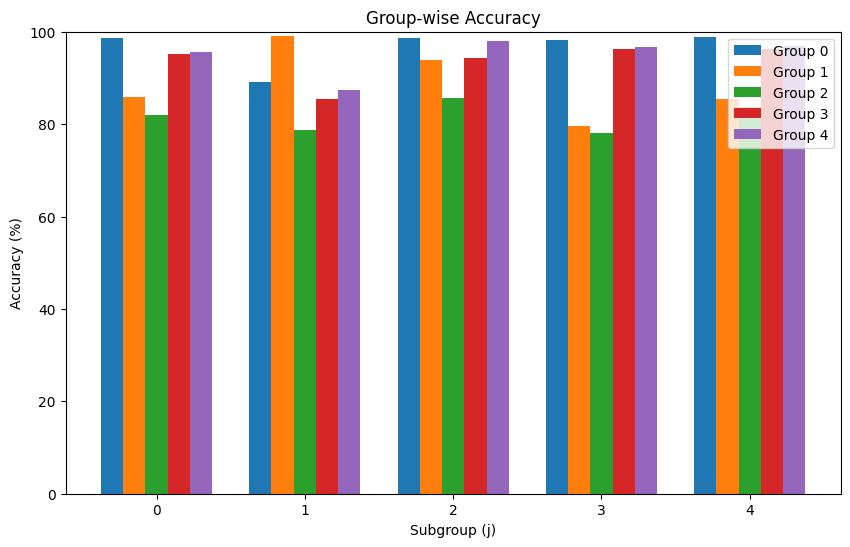

In [36]:
print(evaluator.accuracies)

import matplotlib.pyplot as plt

accuracy_dict = evaluator.accuracies

groups = sorted(set(key[0] for key in accuracy_dict.keys()))
subgroups = sorted(set(key[1] for key in accuracy_dict.keys()))

data = [[accuracy_dict[(i, j)] for j in subgroups] for i in groups]

# Bar graph parameters
x = np.arange(len(subgroups))  # x locations for subgroups
width = 0.15  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each group
for i, group_data in enumerate(data):
    ax.bar(x + i*width, group_data, width, label=f'Group {i}')

# Labels and formatting
ax.set_xlabel('Subgroup (j)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Group-wise Accuracy')
ax.set_xticks(x + width * (len(groups)-1)/2)
ax.set_xticklabels(subgroups)
ax.set_ylim(0, 100)
ax.legend()

plt.show()